In [118]:
import sys
import os
import os.path
import io
import csv
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# plt.rcParams.update({'font.size': 16})
import pandas as pd
from scipy.stats import gamma

# Generation of SBATCH files

Batch file creation function :

In [119]:
def batchwriter(pathtofile="analyses/scaling_param/",files_name="simul", time=24, nodes=1, ntaskspernode=1, mem=2, partition="normal", params_names=[], params_values=[],pathtoexe="../../meiosis"):
        if os.path.exists(pathtofile)==False:
            os.makedirs(pathtofile)
        batchfile= open("{0}Run_{1}.sh".format(pathtofile,files_name),"w+")
        batchfile.write("#!/bin/bash\n")
        batchfile.write("#SBATCH --partition={0}\n".format(partition))
        batchfile.write("#SBATCH --time={0}:00:00\n".format(time))
        batchfile.write("#SBATCH --nodes={0}\n".format(nodes))
        batchfile.write("#SBATCH --ntasks-per-node={0}\n".format(ntaskspernode))
        batchfile.write("#SBATCH --mem={0}gb\n".format(mem))
        batchfile.write("#SBATCH -o Run_{0}.out\n".format(files_name))
        batchfile.write("#SBATCH -e Run_{0}.err\n".format(files_name))
        batchfile.write("\n")
        batchfile.write(pathtoexe)
        for param in range(len(params_names)):
            batchfile.write(" -"+params_names[param]+" {0}".format(params_values[param]))
        batchfile.write(" Run_{0}".format(files_name))
        batchfile.close()

In [3]:
#batchwriter(files_name="V4",params_names=["u","v","w","N"],params_values=[1e-5,1e-4,1e-2,10000],pathtoexe="./meiosis")
batchwriter()

Creation of directory of batch files :

In [355]:
def scaling_U(params_list=["1e-2","1e-3","1e-4","1e-5","1e-6","1e-7","1e-8"],N=1000,nbGenerations=10000,time=24,path_to_folder="analyses/",path_to_exe="../../meiosis",v=1e-4):
    index_u=1
    path=path_to_folder+"scaling_U_{0}/".format(index_u)
    print(os.path.exists(path))
    while os.path.exists(path):
        index_u+=1
        path=path_to_folder+"scaling_U_{0}/".format(index_u)
        print(path)
    for i in range (len(params_list)):
        batchwriter(pathtofile=path,files_name="U_{0}".format(params_list[i]), params_names=["u","N","nbGenerations","v"], params_values=[float(params_list[i]),N,nbGenerations,v],pathtoexe=path_to_exe,time=time)

In [356]:
scaling_U(N=200,nbGenerations=100000,time=72,path_to_folder="analyses/",path_to_exe="../../meiosis",v=5e-4)

True
analyses/scaling_U_2/
analyses/scaling_U_3/
analyses/scaling_U_4/
analyses/scaling_U_5/
analyses/scaling_U_6/


In [357]:
def scaling_V(params_list=["1e-2","1e-3","1e-4","1e-5","1e-6","1e-7","1e-8"],N=1000,nbGenerations=10000,time=24,path_to_folder="analyses/",path_to_exe="../../meiosis",u=1e-4):
    index_v=1
    path=path_to_folder+"scaling_V_{0}/".format(index_v)
    print(os.path.exists(path))
    while os.path.exists(path):
        index_v+=1
        path=path_to_folder+"scaling_V_{0}/".format(index_v)
        print(path)
    for i in range (len(params_list)):
        batchwriter(pathtofile=path,files_name="V_{0}".format(params_list[i]), params_names=["v","N","nbGenerations","u"], params_values=[float(params_list[i]),N,nbGenerations,u],pathtoexe=path_to_exe,time=time)

In [358]:
scaling_V(N=200,nbGenerations=100000,time=72,path_to_folder="analyses/",path_to_exe="../../meiosis",u=5e-4)

True
analyses/scaling_V_2/
analyses/scaling_V_3/
analyses/scaling_V_4/
analyses/scaling_V_5/
analyses/scaling_V_6/


In [64]:
def scaling_N(params_list=["1e3","1e4","1e5","1e6"]):
    index_N=1
    path="analyses/scaling_N_{0}/".format(index_N)
    print(os.path.exists(path))
    while os.path.exists(path):
        index_N+=1
        path="analyses/scaling_N_{0}/".format(index_N)
        print(path)
    for i in range (len(params_list)):
        batchwriter(pathtofile=path,files_name="N_{0}".format(params_list[i]), params_names=["N"], params_values=[float(params_list[i])],pathtoexe="../../meiosis")

In [65]:
scaling_N()

True
analyses/scaling_N_2/
analyses/scaling_N_3/
analyses/scaling_N_4/


In [350]:
def scaling_M(params_list=["1e-1","1e-2","1e-3","1e-4","1e-5","1e-6","1e-7","1e-8"], nbgenmig=4000,N=1000,u=1e-4,v=1e-4,time=24,path_to_folder="analyses/",path_to_exe="../../meiosis"):
    index_m=1
    path=path_to_folder+"scaling_M_{0}/".format(index_m)
    print(os.path.exists(path))
    while os.path.exists(path):
        index_m+=1
        path=path_to_folder+"scaling_M_{0}/".format(index_m)
        print(path)
    for i in range (len(params_list)):
        batchwriter(pathtofile=path,files_name="M_{0}".format(params_list[i]), params_names=["m","nbgenmig","N","u","v"], params_values=[float(params_list[i]),nbgenmig,N,u,v],pathtoexe=path_to_exe,time=time)

In [353]:
scaling_M(params_list=["1e-1","3e-1","1e-2","3e-3","1e-3","3e-4","1e-4","3e-5","1e-5","3e-6","1e-6","3e-7","1e-7","3e-8","1e-8"],time=48,u=1e-5,v=1e-3)

True
analyses/scaling_M_2/
analyses/scaling_M_3/
analyses/scaling_M_4/
analyses/scaling_M_5/
analyses/scaling_M_6/
analyses/scaling_M_7/


# Interpretations

## Panmictic

Function for reading files :

In [2]:
"""def readfiles(pathtofile, file_name, ext_name):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                for j in range(len(lin)):
                    data[params[j]].append(float(lin[j]))
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
    return (data)"""

In [146]:
def readfiles(pathtofile, file_name, ext_name,withoutneutral,withoutnan):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                for j in range(len(lin)):
                    if ext_name == "allele":
                        if withoutneutral==1 and float(lin[1]) != -3 :
                            if withoutnan == 0:
                                data[params[j]].append(float(lin[j]))
                            elif withoutnan ==1 :
                                if lin[5]!="-nan" and lin[6]!="-nan":
                                    data[params[j]].append(float(lin[j])) 
                        elif withoutneutral==0:
                            if withoutnan == 0:
                                data[params[j]].append(float(lin[j]))
                            elif withoutnan ==1 :
                                if lin[5]!="-nan" and lin[6]!="-nan":
                                    data[params[j]].append(float(lin[j]))
                    else :
                        data[params[j]].append(float(lin[j]))
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
    return (data)

In [164]:
a=readfiles('analyses/scaling_V_4/','Run_V_1e-4','allele',0,0)
#len(a["Generation_number"])
print(a)
#print(readfiles("simuU5","trace"))
#sorted(os.listdir('analyses/scaling_V_2/'))

{'Generation_number': [0.0, 0.0, 10.0, 10.0, 20.0, 20.0, 30.0, 30.0, 40.0, 40.0, 50.0, 50.0, 50.0, 50.0, 60.0, 60.0, 60.0, 70.0, 70.0, 70.0, 70.0, 80.0, 80.0, 90.0, 90.0, 90.0, 100.0, 100.0, 100.0, 110.0, 110.0, 110.0, 120.0, 120.0, 120.0, 130.0, 130.0, 140.0, 140.0, 150.0, 150.0, 160.0, 160.0, 160.0, 170.0, 170.0, 180.0, 180.0, 190.0, 190.0, 190.0, 200.0, 200.0, 210.0, 210.0, 210.0, 220.0, 220.0, 220.0, 230.0, 230.0, 230.0, 240.0, 240.0, 240.0, 240.0, 250.0, 250.0, 250.0, 250.0, 260.0, 260.0, 260.0, 270.0, 270.0, 270.0, 280.0, 280.0, 280.0, 280.0, 280.0, 290.0, 290.0, 290.0, 300.0, 300.0, 300.0, 300.0, 310.0, 310.0, 310.0, 310.0, 310.0, 310.0, 320.0, 320.0, 320.0, 320.0, 330.0, 330.0, 330.0, 340.0, 340.0, 340.0, 340.0, 350.0, 350.0, 350.0, 350.0, 360.0, 360.0, 360.0, 370.0, 370.0, 370.0, 370.0, 370.0, 370.0, 380.0, 380.0, 380.0, 380.0, 380.0, 390.0, 390.0, 390.0, 390.0, 400.0, 400.0, 400.0, 400.0, 410.0, 410.0, 410.0, 410.0, 420.0, 420.0, 420.0, 420.0, 420.0, 430.0, 430.0, 430.0, 430.

Function for ploting data :

In [163]:
def plot_data(target_folder_path,x_params,y_params, file_ext,withoutneutral,list_start): #list_start = [start of each simul]
    list_files = sorted(os.listdir(target_folder_path))
    #plt.figure(1, figsize=(20,20))
    index_line=1
    #n=(len(list_files)/6)*len(params_names)
    for file_name in list_files :
        if file_name.split(".")[1]==file_ext :
            plt.figure(1, figsize=(20,20))
            data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],withoutneutral,0)
            #print(params)
            n=len(data_file[x_params])
            plt.subplot(len(list_files)/6,1,index_line)
            plt.plot(data_file[x_params][list_start[index_line-1]:n], data_file[y_params][list_start[index_line-1]:n],'.')
            plt.plot(data_file[x_params][list_start[index_line-1]:n],np.ones((len(data_file[x_params][list_start[index_line-1]:n]),1), dtype = float)*np.mean(data_file[y_params][list_start[index_line-1]:n]) ,'r--')
            plt.ylabel(y_params, fontsize = 12)
            plt.xlabel(x_params+"_for_run_"+(file_name.split(".")[0]).split("_")[2], fontsize = 12)
            index_line=index_line+1

### Individual : Temporal graphs

In [399]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Diversity", file_ext="trace",withoutneutral=0,list_start=[0,0,0,0,0,0,0,0])

The more the v decreases, the more the diversity decreases
We can also observe that when v is low, the regim is mostly a successive regim with some polymorphic phases (around 2 alleles) and when v is high, the rigim is rapidly polymorphic
Maybe for v = 1e-6 the diversity will increase later => not enough long

In [401]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Activity", file_ext="trace",withoutneutral=0,list_start=[0,0,0,0,0,0,0,0])

We observe that the higher the v, the lower the activity. When v is high, the activity is more variable.

In [404]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Fertility_rate", file_ext="trace",withoutneutral=0,list_start=[0,0,0,0,0,0,0,0])

When v is high, we observe a trend with sinusoidal variations for the fertility rate. V is between 0.9 and 0.98.
When v is low, there is no trend any more. We observe a cloud of point centered around the value 0.99.
the higher the v, the lower the fertility rate. This is consitent with the fact that if there is no erosion of sites by mutation, the PRDM9 protein will always be able to link these sites. But, in the other side, if the mutation rate is high, there will be more sites inactivated, the protein will not be able to bind to all the sites and the probability of having a symetrical binding will decrease until a new allele appears in the pop with much less eroded sites.

In [408]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="q", file_ext="trace",withoutneutral=0,list_start=[0,0,0,0,0,0,0,0])

q = the probability of symmetrical binding = nb of symetrical binding with at least one DSB / nb of DSB
Same as the fertility rate : trend when v is high, cloud of point for low v.
the higher the v, the lower the q. Same principle as the fertility rate.

In [418]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Frequency", file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

Here we can see that when v is low, the regim is successive and when v is high the regim is polymorphic. This show that when the sites are to much eroded, it lead to the emergence of new alleles => positive selection for new alleles of PRDM9 recognizing new sites. But, when the sites are not eroded, there is no reason to change the PRDM9 allele. This happen only when the sites targeted by the PRDM9 allele currently segregating in the pop are to much eroded, then a new allele appears.

In [415]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Activity",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

Sites activities associated to each PRDM9 allele. When, v is low, the activity doesn't change and stay at 1. But when v is high, the sites are eroded more rapidly.

In [422]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Age",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

The lower the v, the gigher the maximum age. We also observe that when v is high, there are many alleles but when v is low, there is very few alleles (1 or 2)

In [424]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="q_allele",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

Here, we can see that the higher the v, the lower and the more variable the q. We can observe a sort of trend when v is high even if it is not well drawn.
When v is high, there is more erosion of sites so the probability of having a symmetrical binding (2 activated sites bound by PRDM9 with one experiencing a DSB). In this case we also predict that when a new allele appear in the population, the q will increase => consistent with the sinusoidal trend and mean q.

In [432]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Generation_number",y_params="Fertility_allele",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

The higher the v the more variable the fertility rate. Also, the higher the v, the lower the mean fertility rate. That is coherent with the q observed prviously.
When the sites are more eroded, the probbility of having a symmetrical binding is lower leading to a lower fertility rate.

In [435]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Generation_number",y_params="Diversity", file_ext="trace",withoutneutral=0,list_start=[0,0,0,0,0,0,0,0])

Here we can see that when u is high there is a higher diversity which is completely normal because u correspond to the appearence of new alleles.
We can also see the two regim : successive regim when u < 1e-5 and polymorphic regim when u > 1e-4.

In [439]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Generation_number",y_params="Activity", file_ext="trace",withoutneutral=0,list_start=[0,0,0,0,0,0,0,0])

The lower the u the lower the minimum activity.
Here too we can observe the two regims.
We can see that the activity is decreasing with the same speed (same v) but when u is to low, there is a much lower probability of having a new allele PRDM9 in the population. That's why the activity stay around 0 for a long time. And when finally a new allele appear it invade directly the population.

In [443]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Generation_number",y_params="Fertility_rate", file_ext="trace",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

What we an observe here is that when u is high the fertility rate is stable at a high value but when u is low, the fertility rate decreases to a plateau and when a new allele appears the fertility rate increase to 1. We can also see that the plateau has not all the same value.

In [446]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Generation_number",y_params="q", file_ext="trace",withoutneutral=0,list_start=[0,0,0,0,0,0,0,0])

the lower the u, the lower the minimum q.
Consistent with fertiltiy rate
I don't understand why the q is the same but not the fertility rate (mabe because q takes into account no sym binding but not no DSB and fertiltiy takes into account no DSB and no sym binding => when activity close to 0 when there is a DSB there is always a sym binding : q high, but the site has to experience a DSB) ????

In [465]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Generation_number",y_params="Frequency", file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

We can see the two regims : successive regim when u < 1e-4 and polymorphic regim when u > 1e-4

In [464]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Generation_number",y_params="Activity",file_ext="allele",withoutneutral=0,list_start=[0,0,0,0,0,0,0,0])

Activity corresponding to each allele. Consistent with mean activity

In [456]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Generation_number",y_params="Age",file_ext="allele",withoutneutral=0,list_start=[0,0,0,0,0,0,0,0])

When the regim is highly polymorphic, each allele has a relatively short lifetime which is not the case when the regim is successive.

In [463]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Generation_number",y_params="q_allele",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

The higher the u the more variable the q and the low the minimum q. This come from the fact that when there are a lot of alleles segregating in the population, there is a highest probability of having alleles recognizing sites with poor activity. Also when the sites are not enough eroded, the PRDM9 protein has a bigger choice for binding so there is a higher probability of having a non symetrical binding.

In [466]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Generation_number",y_params="Fertility_allele",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

It is the same as the mean fertility concerning the low u. But for the higher u, the fertility is much more variable but the mean is really high due to the great amount of allele in the population

### Polymorphic regim

In [148]:
def plot_regim(target_folder_path,x_param,y_params,file_name,withoutneutral,time_stable,larg,long):
    data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],withoutneutral,0)
    print(file_name)
    index_line=1
    plt.figure(1, figsize=(long,larg))
    n=len(data_file[x_param])
    for param in y_params:
        plt.subplot(len(y_params),1,index_line)
        plt.plot(data_file[x_param][time_stable:n], data_file[param][time_stable:n],'.')
        plt.plot(data_file[x_param][time_stable:n],np.ones((len(data_file[x_param][time_stable:n]),1), dtype = float)*np.mean(data_file[param][time_stable:n]) ,'r--')
        plt.ylabel(param, fontsize = 12)
        plt.xlabel(x_param, fontsize = 12)
        index_line=index_line+1

Run_U_1e-4.allele


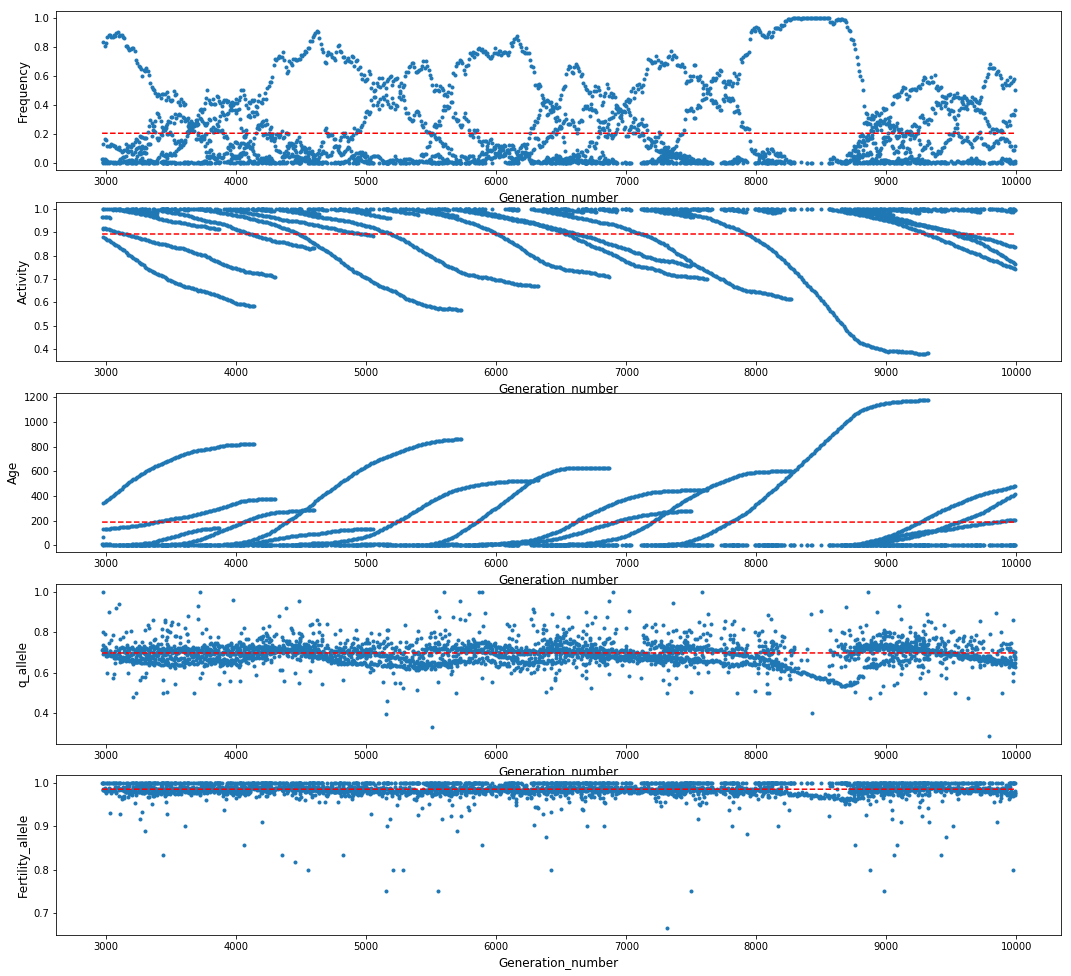

In [471]:
plot_regim(target_folder_path="analyses/scaling_U_4/",x_param="Generation_number",y_params=["Frequency","Activity","Age","q_allele","Fertility_allele"],file_name="Run_U_1e-4.allele",withoutneutral=1,time_stable=1000,larg=17,long=18)

In [470]:
#plot_regim(target_folder_path="analyses/scaling_U_4/",x_param="Age",y_params=["Frequency","Activity","q_allele","Fertility_allele"],file_name="Run_U_1e-4.allele",withoutneutral=1,time_stable=0,larg=17,long=18)

### Successive regim

In [362]:
#plot_regim(target_folder_path="analyses/scaling_U_4/",x_param="Generation_number",y_params=["Frequency","Activity"],file_name="Run_U_1e-5.allele",withoutneutral=1,time_stable=100,larg=7,long=18)

Run_U_1e-5.allele


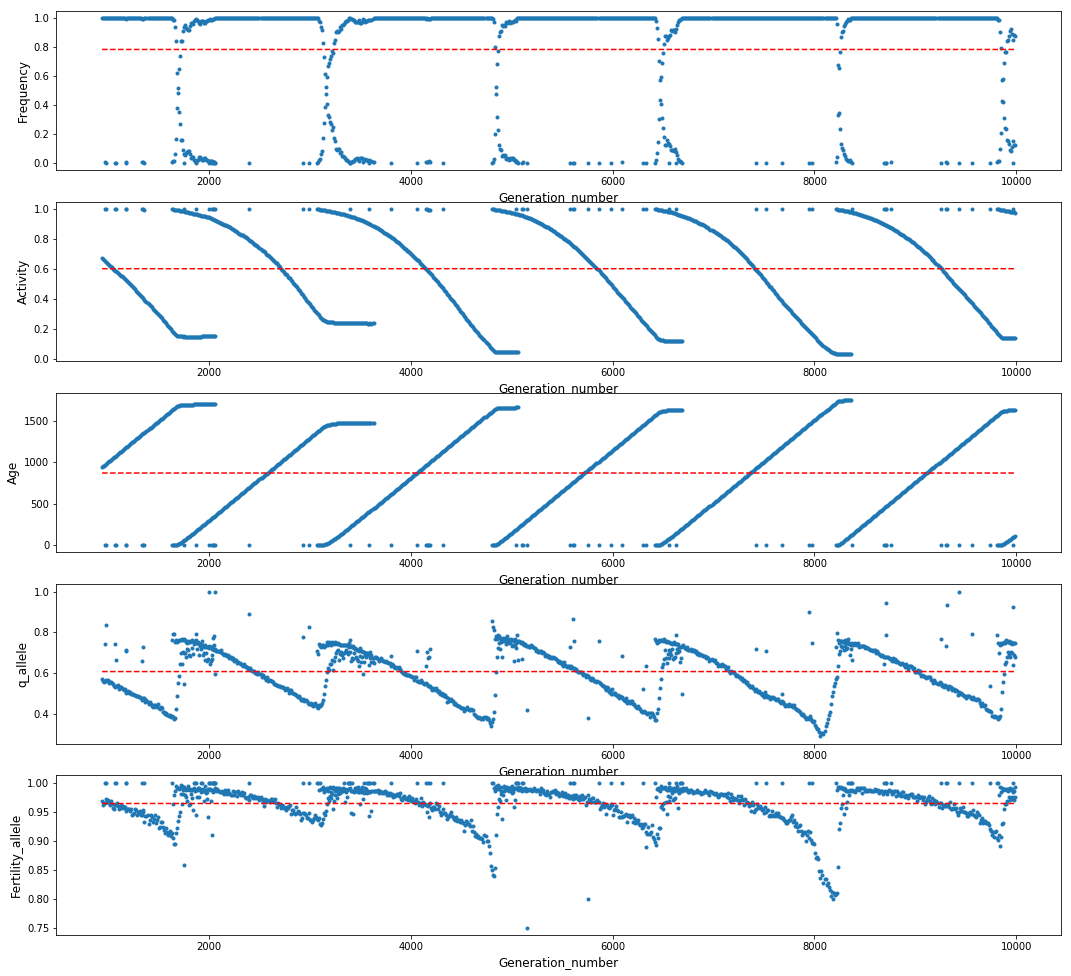

In [480]:
plot_regim(target_folder_path="analyses/scaling_U_4/",x_param="Generation_number",y_params=["Frequency","Activity","Age","q_allele","Fertility_allele"],file_name="Run_U_1e-5.allele",withoutneutral=1,time_stable=100,larg=17,long=18)

In [479]:
#plot_regim(target_folder_path="analyses/scaling_U_4/",x_param="Age",y_params=["Frequency","Activity","q_allele","Fertility_allele"],file_name="Run_U_1e-5.allele",withoutneutral=1,time_stable=0,larg=17,long=18)

### Individual : Params vs age

In [328]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Age",y_params="Frequency", file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

In [332]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Age",y_params="Activity", file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

In [334]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Age",y_params="q_allele",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

In [228]:
#plot_data(target_folder_path="analyses/scaling_V_4/",x_params="Age",y_params="Fertility_allele",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

In [201]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Age",y_params="Frequency", file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

In [331]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Age",y_params="Activity", file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

In [203]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Age",y_params="q_allele",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

In [204]:
#plot_data(target_folder_path="analyses/scaling_U_4/",x_params="Age",y_params="Fertility_allele",file_ext="allele",withoutneutral=1,list_start=[0,0,0,0,0,0,0,0])

In [189]:
def graph_per_allele(target_folder_path, file_name, ext_name, x_axis_param, y_axis_param,withoutneutral):
    data = readfiles(target_folder_path, file_name, ext_name,withoutneutral,0)
    x_per_allele=dict()
    y_per_allele=dict()
    for i in range(len(data["Generation_number"])):
        cle = data['Allele_number'][i]
        if ((str(cle) in x_per_allele) == False and cle!=-3):
            x_per_allele[str(cle)]=[]
            x_per_allele[str(cle)].append(data[x_axis_param][i])
            y_per_allele[str(cle)]=[]
            y_per_allele[str(cle)].append(data[y_axis_param][i])
        elif ((str(cle) in x_per_allele) == True and cle!=-3):
            x_per_allele[str(cle)].append(data[x_axis_param][i])
            y_per_allele[str(cle)].append(data[y_axis_param][i])
    return(x_per_allele,y_per_allele)

In [190]:
(X,Y)=graph_per_allele("analyses/scaling_V_2/", 'Run_V_1e-4', 'allele', "q_allele", "Age",1)

Text(0.5,0,'Age')

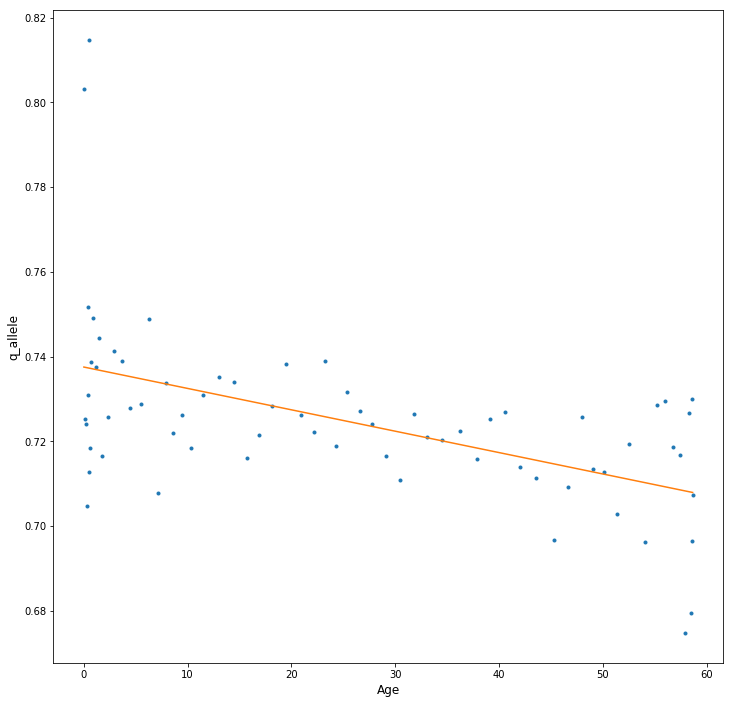

In [192]:
allele_nb = '73.0'
(X,Y)=graph_per_allele("analyses/scaling_V_2/", 'Run_V_1e-4', 'allele', "Age", "q_allele",1)
lm1 = LinearRegression().fit(np.array(X[allele_nb]).reshape(-1, 1), np.array(Y[allele_nb]))
plt.figure(1, figsize=(12,12))
plt.plot(X[allele_nb], Y[allele_nb], '.')
plt.plot(X[allele_nb], lm1.predict(np.array(X[allele_nb]).reshape(-1, 1)))
plt.ylabel('q_allele', fontsize = 12)
plt.xlabel('Age', fontsize = 12)

In [193]:
#print(np.array(Y[allele_nb]))
#print(lm1.predict(np.array(X[allele_nb]).reshape(-1, 1)))
score_lm1 = r2_score(np.array(Y[allele_nb]),lm1.predict(np.array(X[allele_nb]).reshape(-1, 1)))
print("R2 score : ",score_lm1)
print('intercept:', lm1.intercept_)
print('slope:', lm1.coef_)

R2 score :  0.269792224568
intercept: 0.7375572852
slope: [-0.00050471]


### Scaling

In [55]:
def readscalingexperiment(target_folder_path , scaling_param_name, param_names_allele, param_names_trace,withoutneutral):
    list_files = sorted(os.listdir(target_folder_path))
    stat_dict_allele = dict()
    for param in param_names_allele:
        stat_dict_allele[scaling_param_name]=[]
        stat_dict_allele[param+"_mean"]=[]
        stat_dict_allele[param+"_variance"]=[]
    stat_dict_trace = dict()
    for param in param_names_trace:
        stat_dict_trace[scaling_param_name]=[]
        stat_dict_trace[param+"_mean"]=[]
        stat_dict_trace[param+"_variance"]=[]
    for file_name in list_files :
        if file_name.split(".")[1]=="allele" :
            stat_dict_allele[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            data_file = readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],withoutneutral,0)
            for key in data_file.keys():
                (stat_dict_allele[key+"_mean"]).append(np.mean(data_file[key]))
                (stat_dict_allele[key+"_variance"]).append(np.var(data_file[key]))
        elif file_name.split(".")[1]=="trace" :
            stat_dict_trace[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            data_file = readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],withoutneutral,0)
            for key in data_file.keys():
                (stat_dict_trace[key+"_mean"]).append(np.mean(data_file[key]))
                (stat_dict_trace[key+"_variance"]).append(np.var(data_file[key]))
    return (stat_dict_allele,stat_dict_trace)

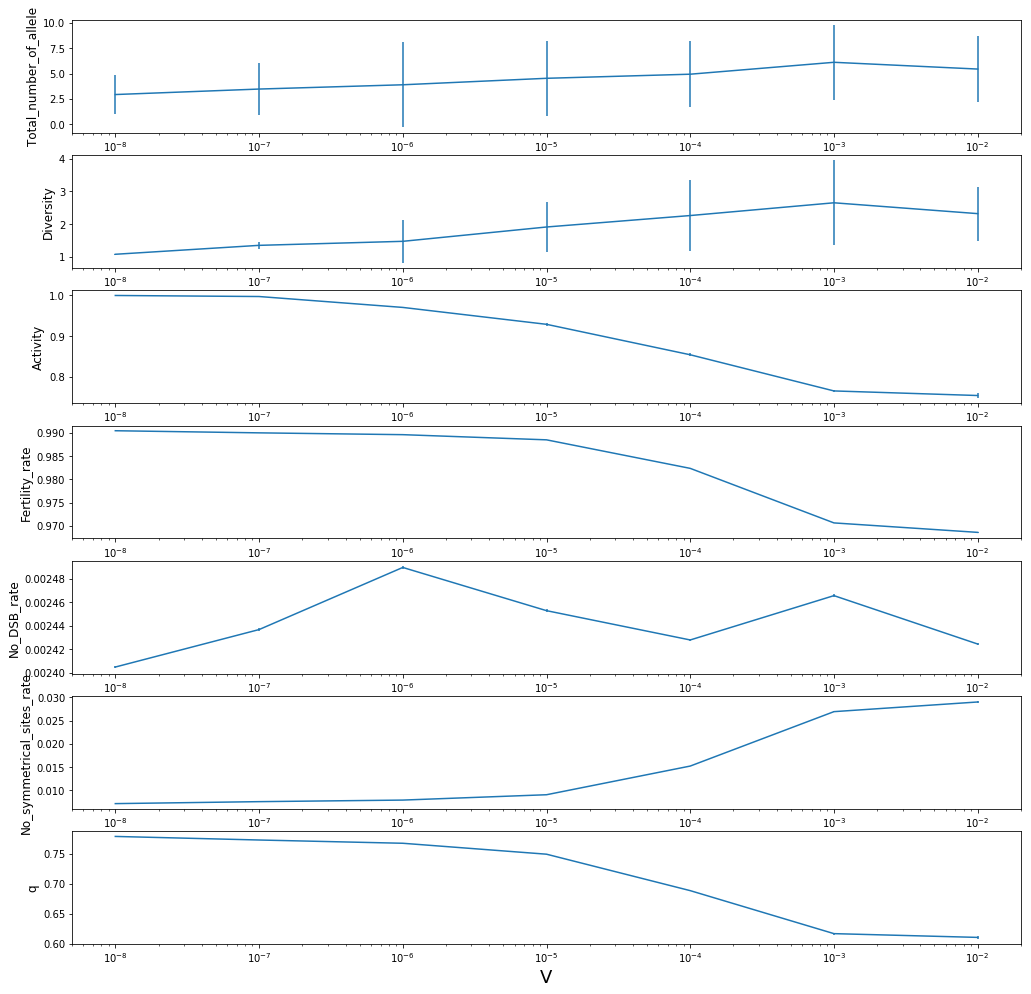

In [485]:
(allele,trace)=readscalingexperiment(target_folder_path="analyses/scaling_V_4/" , scaling_param_name="V", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele","Fertility_allele","mean_affinity"], param_names_trace=["Generation_number","Total_number_of_allele","Diversity","Activity","Mean_Age","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q","q_intra","fertility_intra"],withoutneutral=0)
scaling_param_name="V"
param_to_plot=["Total_number_of_allele","Diversity","Activity","Fertility_rate","No_DSB_rate","No_symmetrical_sites_rate","q"]
n=len(param_to_plot)
#d=6
#h=400
#g=d/(4*h)
#for j in range(len(trace[scaling_param_name])):
#    trace[scaling_param_name][j]=trace[scaling_param_name][j]*g

plt.figure(1, figsize=(17,17))
for index_parameter in range(n):
    plt.subplot(n,1,index_parameter+1)
    plt.errorbar(trace[scaling_param_name], trace[param_to_plot[index_parameter]+'_mean'], trace[param_to_plot[index_parameter]+'_variance'])
    plt.xscale('log')
    plt.ylabel(param_to_plot[index_parameter], fontsize = 12)
    plt.xlabel(scaling_param_name, fontsize = 18)

Scaling of v :  
Diversity increases with v : when v is high it leads to a positive selection of new PRDM9 alleles. Effect not really visible  
Activity decreases with v : normal because v acts on the activity of the sites, the higher the v the lower the activity  
Fertiltity rate decreases with v : when v is high, the probability of binding is lower (praticularly the sym binding) (drop of 3%)  
no sym binding increases with v (2%) : coherent with what I said above for fertility rate  
q decreases with v : coherent with what I said for Fertiltiy rate, when v is high, the probability of having a symetrical binding with DSB is lower than with a low v  

In the article of Latrille the scling are made with vg (erosion rate) against recombination rates, PRDM9 Diversity (and turnovertime). In my case the recombination rate is analogue to the fertility rate.  
If I change to vg (g=d/4h) against the other parameters I obtain something similar to what Latrille had for the diversity and recombination rate.  

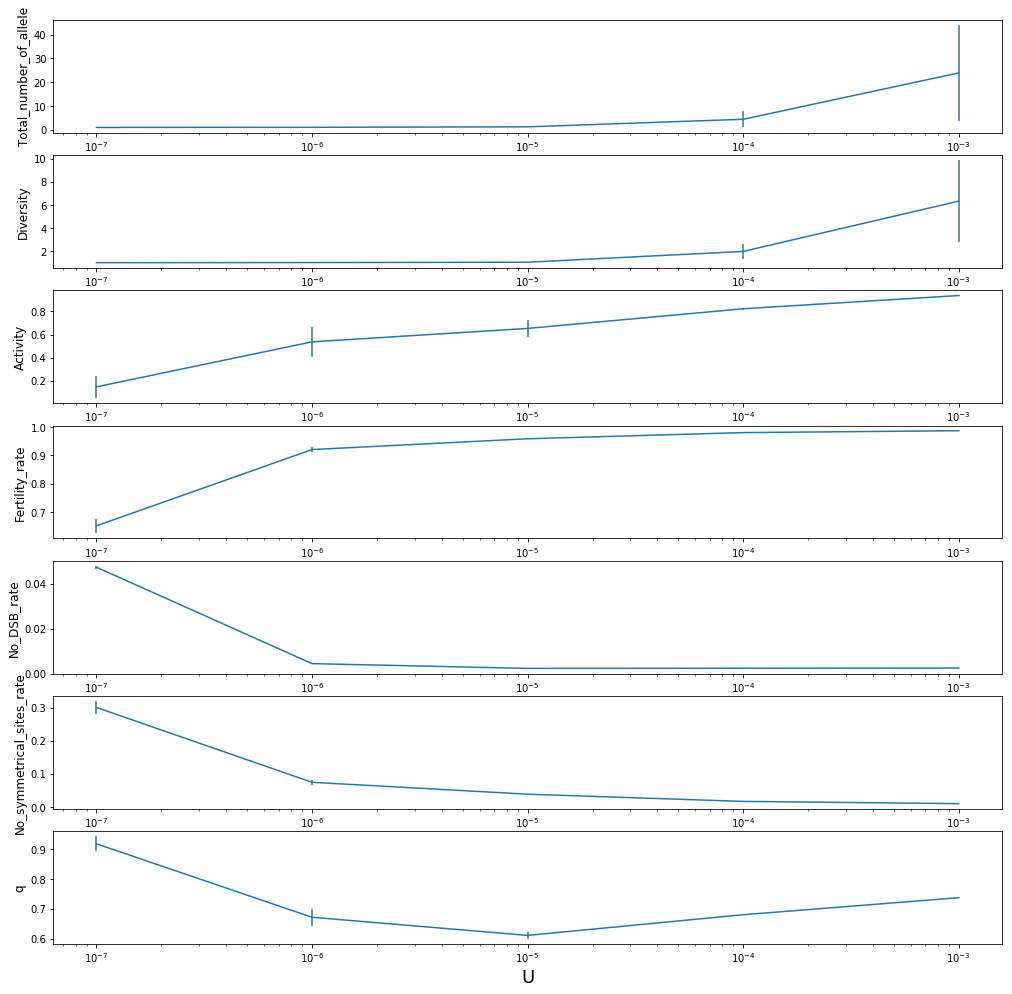

In [487]:
(allele,trace)=readscalingexperiment(target_folder_path="analyses/scaling_U_4/" , scaling_param_name="U", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele","Fertility_allele","mean_affinity"], param_names_trace=["Generation_number","Total_number_of_allele","Diversity","Activity","Mean_Age","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q","q_intra","fertility_intra"],withoutneutral=0)
scaling_param_name="U"
param_to_plot=["Total_number_of_allele","Diversity","Activity","Fertility_rate","No_DSB_rate","No_symmetrical_sites_rate","q"]
n=len(param_to_plot)

plt.figure(1, figsize=(17,17))
for index_parameter in range(n):
    plt.subplot(n,1,index_parameter+1)
    plt.errorbar(trace[scaling_param_name][1:6], trace[param_to_plot[index_parameter]+'_mean'][1:6], trace[param_to_plot[index_parameter]+'_variance'][1:6])
    plt.xscale('log')
    #plt.yscale('log')
    plt.ylabel(param_to_plot[index_parameter], fontsize = 12)
    plt.xlabel(scaling_param_name, fontsize = 18)

Scaling of u :  
Diversity increases with u : when u is high it leads to a high polymorphic regim with alleles that have nearly the same frequence in the population. If u is low, only one allele dominates.  
Activity increases with u : normal because u acts on the number of alleles. If there are a lot of alleles in the population, the erosion will be distributed among these alleles and the dBGC will act not only on one allele. That means that the sites eroded themseves slower than when u is low (1 allele in the population)  
Fertiltity rate increases with u : when u is high, there are more alleles with less eroded sites so the probability of having a good symetrical binding is high (which is not the case when u is low)  
no sym binding decreases with u (2%) : coherent with what I said above for fertility rate  
q decreases with u until 1e-5 and inreases again : q calculates the probability of having a symetrical binding given that there is at least one DSB. When there is at least one DSB there is usually a binding on the homologue and the q is high. But the fertility rate is low because it takes into account the fact where there is no DSB or no binding at all. This case might be really present in the case of a low u. the q is also high when there are a lot of allele in the population. That means that there are many heterozygous individuals for the PRDM9 locus which increases the probability of having a symetrical binding (2 times more sites). With a u = 1e-5, it could be a transitory state between the two cases I presented before : there are not enough alleles in the pop for having a high activity for each allele but in the other side, there is enough active sites for having a DSB on it but not a symetrical binding.

## Migration

### Individual : Temporal graphs

In [206]:
def dico_data_mig(target_folder_path,x_params,y_params, file_ext, withneutral,withoutnan):
    list_files = sorted(os.listdir(target_folder_path))
    dico_file = dict()
    dico_file_1 = dict()
    dico_file_2 = dict()
    list_namefile=[]
    for file_name in list_files :
        if file_name.split(".")[1]==file_ext :
            if withneutral==1:
                data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],0,withoutnan)
            elif withneutral==0:
                data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],1,withoutnan)
            if (file_name.split(".")[0]).split("_")[-1] == "1" :
                dico_file_1[(file_name.split(".")[0]).split("_")[2]+"_x_params"]=data_file[x_params]
                dico_file_1[(file_name.split(".")[0]).split("_")[2]+"_y_params"]=data_file[y_params]
            if (file_name.split(".")[0]).split("_")[-1] == "2" :
                dico_file_2[(file_name.split(".")[0]).split("_")[2]+"_x_params"]=data_file[x_params]
                dico_file_2[(file_name.split(".")[0]).split("_")[2]+"_y_params"]=data_file[y_params]
            if  x_params in data_file and y_params in data_file :
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_x_params"]=data_file[x_params]
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_y_params"]=data_file[y_params]
            list_namefile.append((file_name.split(".")[0]).split("_")[2])
    list_namefile=sorted(list(set(list_namefile)))
    return (list_namefile,dico_file,dico_file_1,dico_file_2)

In [274]:
def plot_data_mig(target_folder_path,x_params,y_params, file_ext, withneutral, withoutnan):
    plt.figure(1, figsize=(20,30))
    index_line=1
    list_namefile,dico_file,dico_file_1,dico_file_2=dico_data_mig(target_folder_path,x_params,y_params, file_ext, withneutral, withoutnan)
    for i in list_namefile[0:9] :
        plt.subplot(len(list_namefile[0:9]),1,index_line)
        #if i+"_x_params" in dico_file and i+"_y_params" in dico_file:
            #plt.plot(dico_file[i+"_x_params"],dico_file[i+"_y_params"],'.',label="pop before migration")
        plt.plot(dico_file_1[i+"_x_params"],dico_file_1[i+"_y_params"],'.',label="pop1")
        plt.plot(dico_file_2[i+"_x_params"],dico_file_2[i+"_y_params"],'.',label="pop2")
        plt.ylabel(y_params, fontsize = 12)
        plt.xlabel(x_params+"_for_run_"+i, fontsize = 12)
        index_line=index_line+1

In [342]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Diversity","trace",1,0)

The higher the m, the lower the mean diversity  
When there are a lot of migrants, the diversity in the 2 pop is really similar.  
When there are very few migrants, the diversity in each pop is independent from one another.
We expected to have for each parameter the same thing for m 1e-6, 1e-7, 1e-8 and 0 as the simulations for u and v at 1e-4. We also expect to have for m = 1e-1 and 1e-2 the same thing as simulations for u and v at 1e-4 and a pop size multiplied by 2.

In [286]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Activity","trace",1,0)

Same activity when m is high and very variable activity when m is low

In [291]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Fertility_rate","trace",1,0)

The fertility rate is mostly the same and is independent of m. But we can observe that sometimes one population has a lower fertility rate for a short time which could correlate with the end of life of an old allele

In [292]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","q","trace",1,0)

In [224]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","q_intra","trace",1,0)

In [226]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","fertility_intra","trace",1,0)

In [348]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","q_inter","trace",1,0)

In [228]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","fertility_inter","trace",1,0)

In [229]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","FST_neutral","trace",1,0)

In [230]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","FST_PRDM9","trace",1,0)

In [290]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Frequency","allele",0,0)

In [232]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Activity","allele",0,0)

In [294]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Age","allele",0,0)

In [234]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","q_allele","allele",0,0)

In [235]:
#plot_data_mig("analyses/scaling_M_3/","Generation_number","Fertility_allele","allele",0,0)

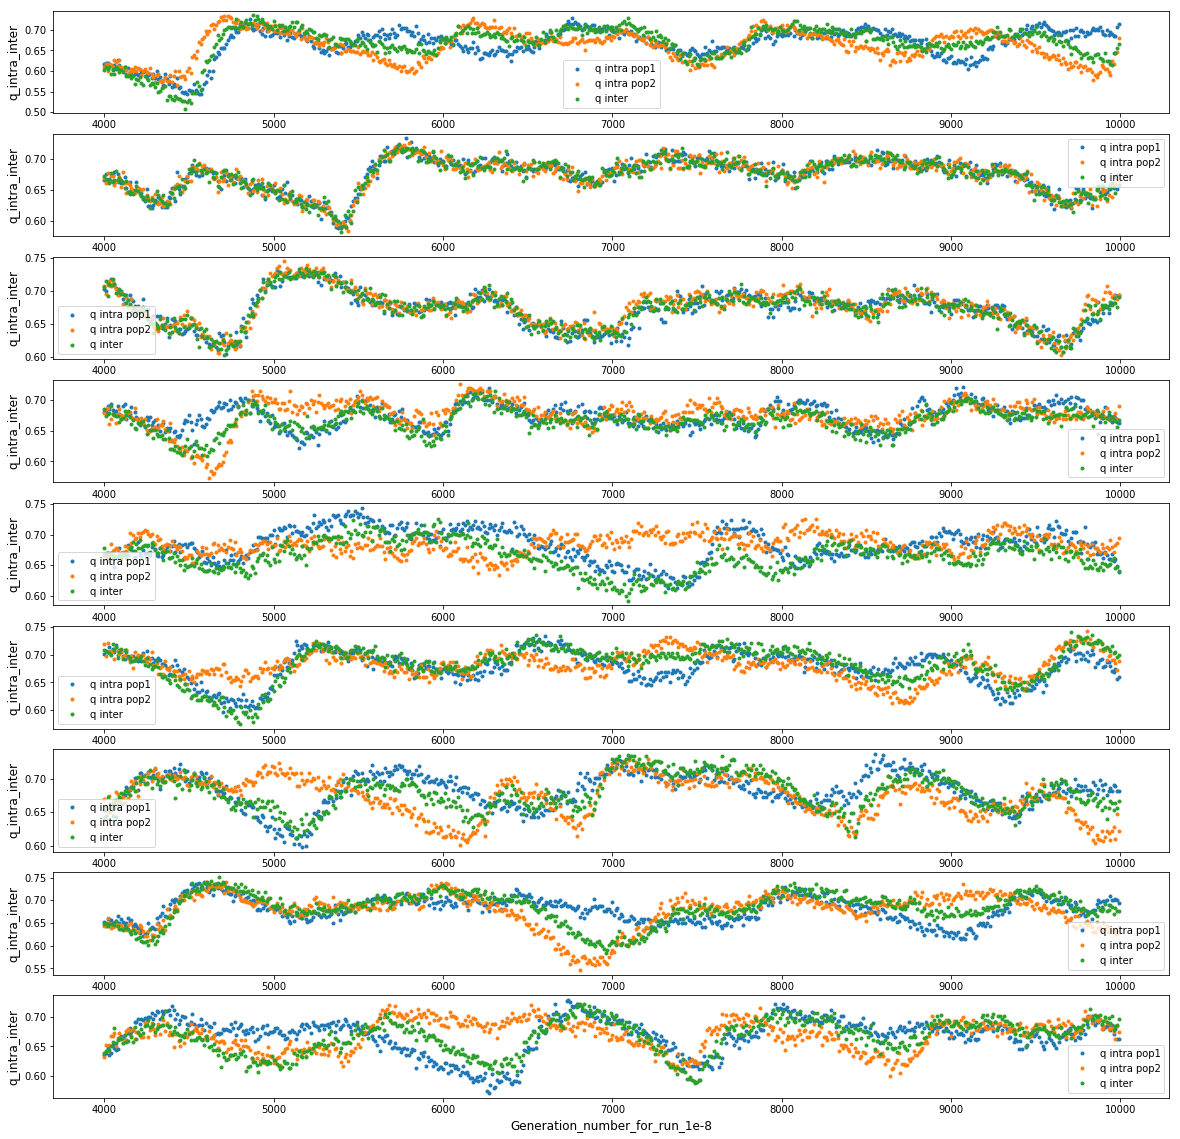

In [319]:
plt.figure(1, figsize=(20,20))
index_line=1
list_namefile,dico_file_inter,dico_file_1_inter,dico_file_2_inter=dico_data_mig("analyses/scaling_M_3/","Generation_number","q_inter", "trace",0,0)
list_namefile,dico_file_intra,dico_file_1_intra,dico_file_2_intra=dico_data_mig("analyses/scaling_M_3/","Generation_number","q_intra", "trace",0,0)
for i in list_namefile :
    plt.subplot(len(list_namefile),1,index_line)
    #if i+"_x_params" in dico_file_intra and i+"_y_params" in dico_file_intra:
        #plt.plot(dico_file_intra[i+"_x_params"],dico_file_intra[i+"_y_params"],'.',label="q intra before mig")
    plt.plot(dico_file_1_intra[i+"_x_params"],dico_file_1_intra[i+"_y_params"],'.',label="q intra pop1")
    plt.plot(dico_file_2_intra[i+"_x_params"],dico_file_2_intra[i+"_y_params"],'.',label="q intra pop2")
    plt.plot(dico_file_1_inter[i+"_x_params"],dico_file_1_inter[i+"_y_params"],'.',label="q inter")
    plt.ylabel("q_intra_inter", fontsize = 12)
    plt.xlabel("Generation_number"+"_for_run_"+i, fontsize = 12)
    plt.legend()
    index_line=index_line+1

In [309]:
def plot_regim_mig(target_folder_path,x_param,y_params,files_names,withoutneutral,withoutnan,larg,long):
    data_file_1=readfiles(target_folder_path, files_names[0].split(".")[0], files_names[0].split(".")[1],withoutneutral,withoutnan)
    data_file_2=readfiles(target_folder_path, files_names[1].split(".")[0], files_names[1].split(".")[1],withoutneutral,withoutnan)
    print(files_names)
    index_line=1
    plt.figure(1, figsize=(long,larg))
    for param in y_params:
        plt.subplot(len(y_params),1,index_line)
        plt.plot(data_file_1[x_param], data_file_1[param],'.')
        plt.plot(data_file_1[x_param],np.ones((len(data_file_1[x_param]),1), dtype = float)*np.mean(data_file_1[param]) ,'r--')
        plt.plot(data_file_2[x_param], data_file_2[param],'.')
        plt.plot(data_file_2[x_param],np.ones((len(data_file_2[x_param]),1), dtype = float)*np.mean(data_file_2[param]) ,'r--')
        plt.ylabel(param, fontsize = 12)
        plt.xlabel(x_param, fontsize = 12)
        index_line=index_line+1

['Run_M_0_1.allele', 'Run_M_0_2.allele']


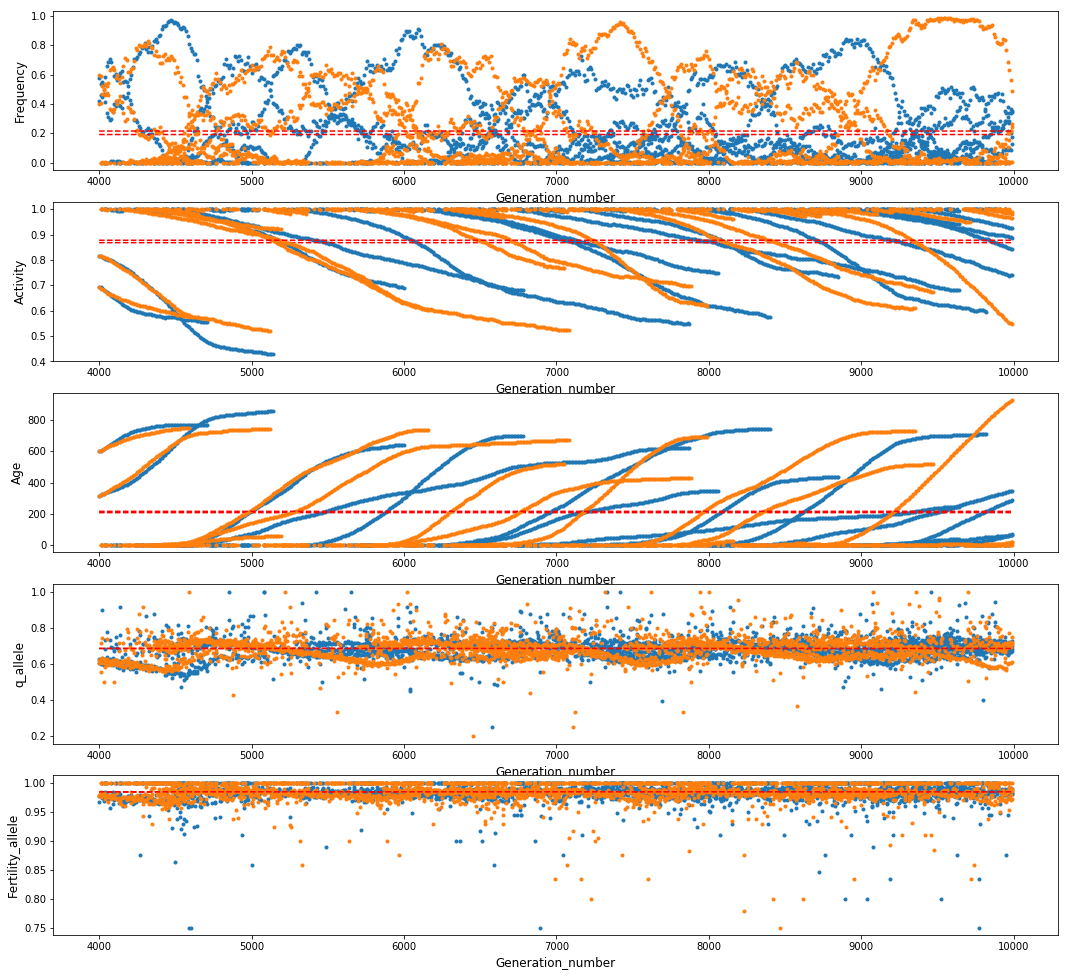

In [371]:
plot_regim_mig(target_folder_path="analyses/scaling_M_3/",x_param="Generation_number",y_params=["Frequency","Activity","Age","q_allele","Fertility_allele"],files_names=["Run_M_0_1.allele","Run_M_0_2.allele"],withoutneutral=1,withoutnan=1,larg=17,long=18)

In [373]:
#plot_regim_mig(target_folder_path="analyses/scaling_M_3/",x_param="Generation_number",y_params=["Frequency","Activity","Age","q_allele","Fertility_allele"],files_names=["Run_M_1e-7_1.allele","Run_M_1e-7_2.allele"],withoutneutral=1,withoutnan=1,larg=17,long=18)

Here we can see that the populations act like there is no migration (similar as above where m=0)

['Run_M_1e-2_1.allele', 'Run_M_1e-2_2.allele']


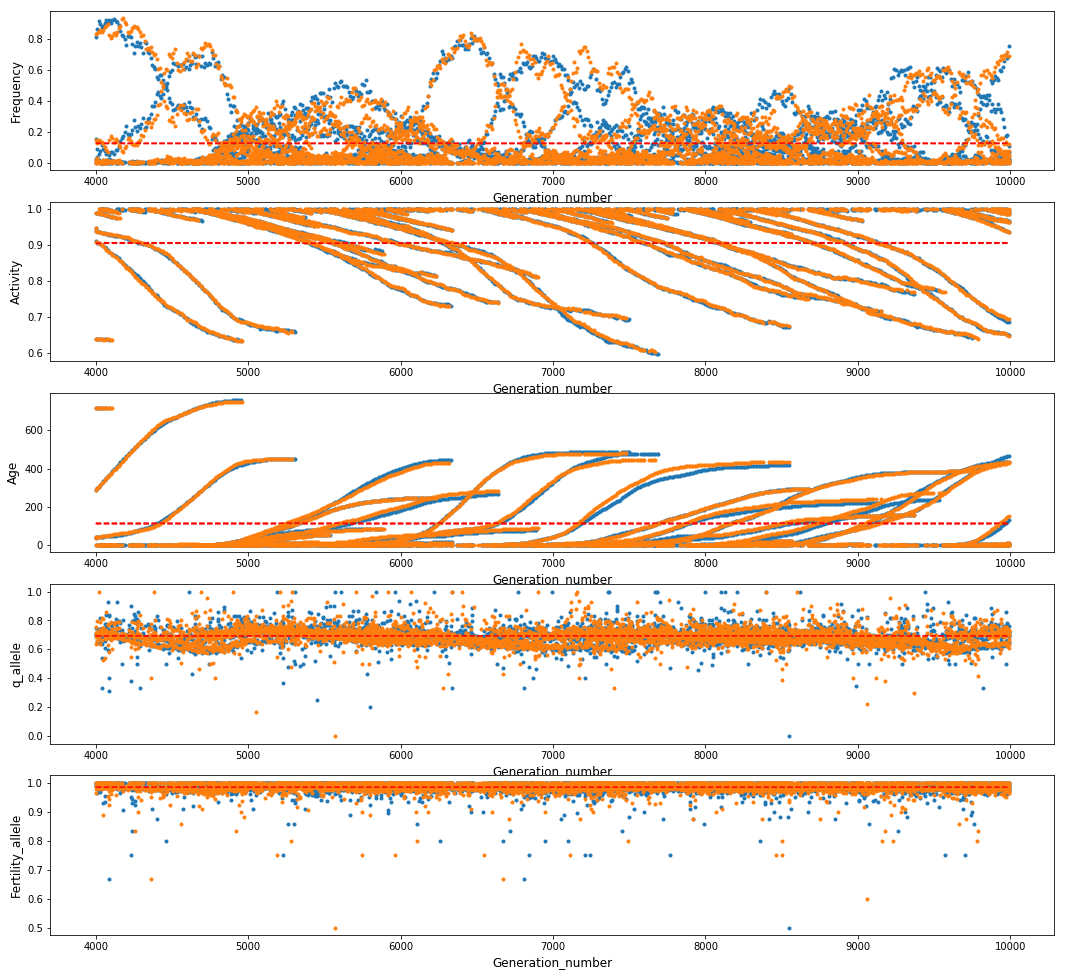

In [374]:
plot_regim_mig(target_folder_path="analyses/scaling_M_3/",x_param="Generation_number",y_params=["Frequency","Activity","Age","q_allele","Fertility_allele"],files_names=["Run_M_1e-2_1.allele","Run_M_1e-2_2.allele"],withoutneutral=1,withoutnan=1,larg=17,long=18)

Here the populations act exactly the same as it was one population

In [377]:
#plot_regim_mig(target_folder_path="analyses/scaling_M_3/",x_param="Generation_number",y_params=["Diversity","Activity","q_intra","fertility_intra","q_inter","fertility_inter"],files_names=["Run_M_1e-2_1.trace","Run_M_1e-2_2.trace"],withoutneutral=1,withoutnan=1,larg=17,long=18)

['Run_M_1e-5_1.allele', 'Run_M_1e-5_2.allele']


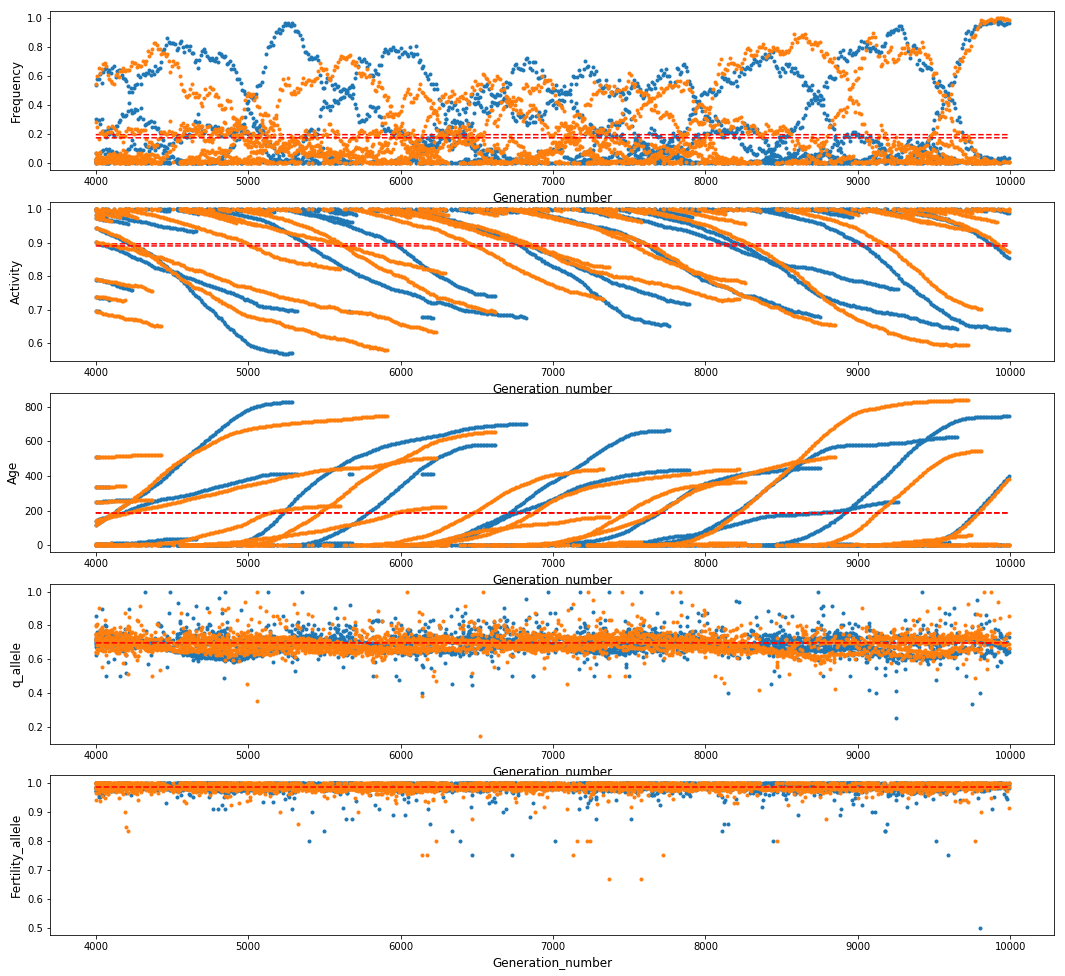

In [378]:
plot_regim_mig(target_folder_path="analyses/scaling_M_3/",x_param="Generation_number",y_params=["Frequency","Activity","Age","q_allele","Fertility_allele"],files_names=["Run_M_1e-5_1.allele","Run_M_1e-5_2.allele"],withoutneutral=1,withoutnan=1,larg=17,long=18)

['Run_M_1e-5_1.trace', 'Run_M_1e-5_2.trace']


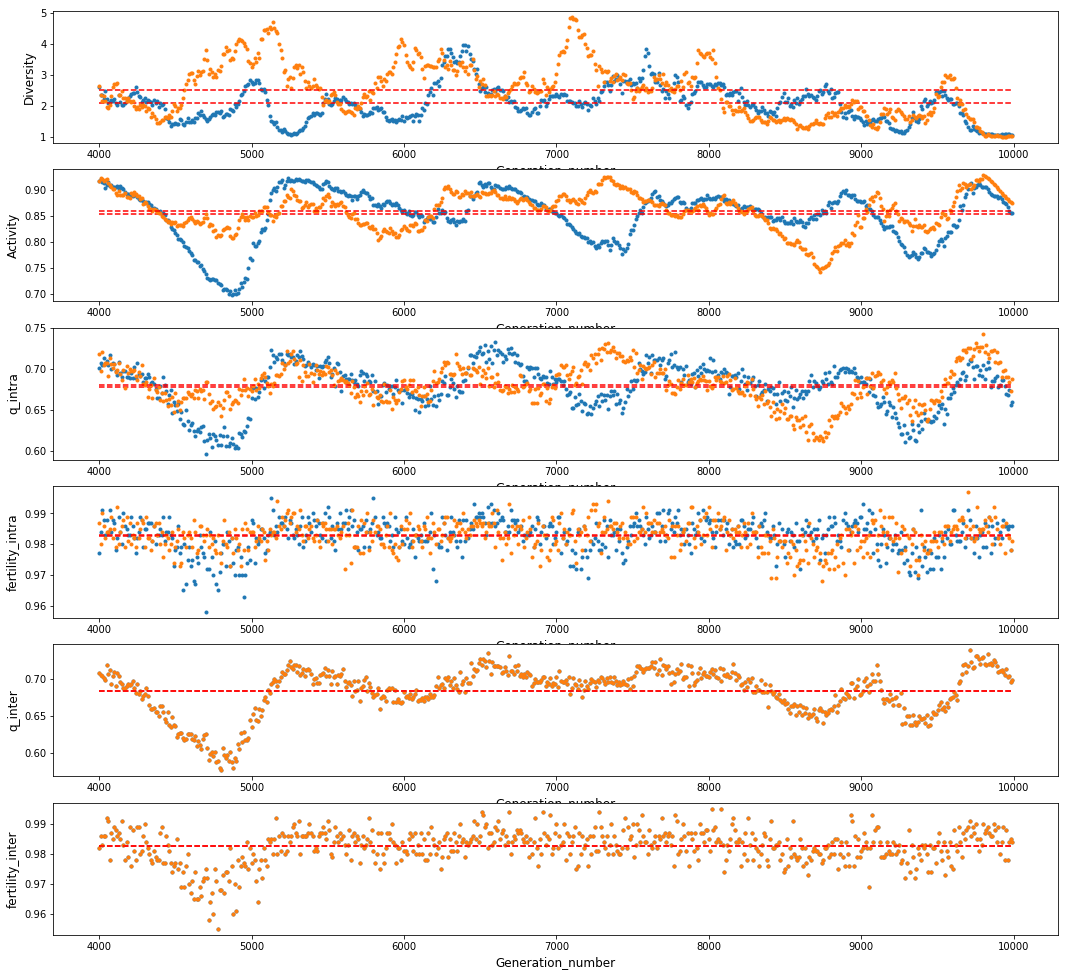

In [379]:
plot_regim_mig(target_folder_path="analyses/scaling_M_3/",x_param="Generation_number",y_params=["Diversity","Activity","q_intra","fertility_intra","q_inter","fertility_inter"],files_names=["Run_M_1e-5_1.trace","Run_M_1e-5_2.trace"],withoutneutral=1,withoutnan=1,larg=17,long=18)

### Individual : Params vs age

In [295]:
#plot_data_mig("analyses/scaling_M_3/","Age","Frequency","allele",0,0)

In [296]:
#plot_data_mig("analyses/scaling_M_3/","Age","Activity","allele",0,0)

In [297]:
#plot_data_mig("analyses/scaling_M_3/","Age","q_allele","allele",0,0)

In [298]:
#plot_data_mig("analyses/scaling_M_4/","Age","Fertility_allele","allele",0,0)

[array([-0.00010585]), array([ -9.18909837e-05]), array([-0.00012209]), array([-0.00012284]), array([-0.00012186]), array([-0.00012545]), array([-0.00010687]), array([-0.00010645]), array([-0.00012009])]
[array([-0.00014488]), array([-0.00020534]), array([-0.00020608]), array([-0.00015562]), array([-0.00016265]), array([-0.00012819]), array([-0.00013086]), array([-0.00013445]), array([-0.00013699])]
[array([-0.00014555]), array([-0.0001995]), array([-0.00019646]), array([-0.00017125]), array([-0.00014655]), array([-0.00013581]), array([-0.00012489]), array([-0.00012094]), array([-0.00014928])]


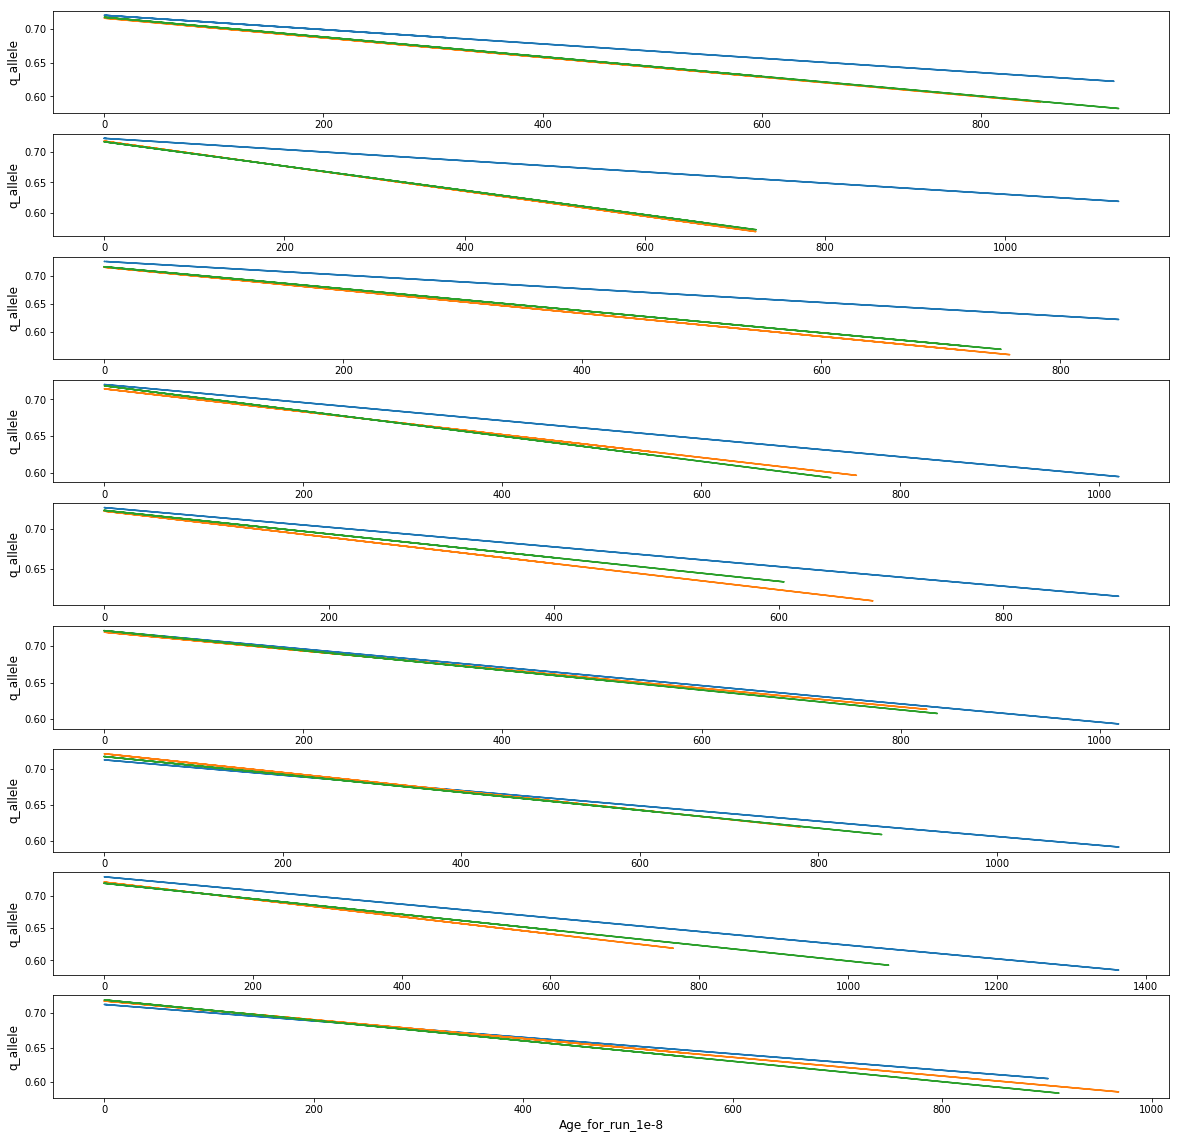

In [220]:
R2_score_list_pop=[]
R2_score_list_pop_1=[]
R2_score_list_pop_2=[]
intercept_list_pop=[]
intercept_list_pop_1=[]
intercept_list_pop_2=[]
slope_list_pop=[]
slope_list_pop_1=[]
slope_list_pop_2=[]
plt.figure(1, figsize=(20,20))
index_line=1
list_namefile,dico_file,dico_file_1,dico_file_2=dico_data_mig("analyses/scaling_M_3/","Age","q_allele","allele",0,1)
for i in list_namefile :
    plt.subplot(len(list_namefile),1,index_line)
    if i+"_x_params" in dico_file and i+"_y_params" in dico_file:
        #plt.plot(dico_file[i+"_x_params"],dico_file[i+"_y_params"],'.',label="pop before migration")
        lm = LinearRegression().fit(np.array(dico_file[i+"_x_params"]).reshape(-1, 1), np.array(dico_file[i+"_y_params"]))
        plt.plot(dico_file[i+"_x_params"], lm.predict(np.array(dico_file[i+"_x_params"]).reshape(-1, 1)))
    #plt.plot(dico_file_1[i+"_x_params"],dico_file_1[i+"_y_params"],'.',label="pop1")
    lm1 = LinearRegression().fit(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1), np.array(dico_file_1[i+"_y_params"]))
    plt.plot(dico_file_1[i+"_x_params"], lm1.predict(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1)))
    #plt.plot(dico_file_2[i+"_x_params"],dico_file_2[i+"_y_params"],'.',label="pop2")
    lm2 = LinearRegression().fit(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1), np.array(dico_file_2[i+"_y_params"]))
    plt.plot(dico_file_2[i+"_x_params"], lm2.predict(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1)))
    plt.ylabel("q_allele", fontsize = 12)
    plt.xlabel("Age"+"_for_run_"+i, fontsize = 12)
    score_lm = r2_score(np.array(dico_file[i+"_y_params"]),lm.predict(np.array(dico_file[i+"_x_params"]).reshape(-1, 1)))
    score_lm1 = r2_score(np.array(dico_file_1[i+"_y_params"]),lm1.predict(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1)))
    score_lm2 = r2_score(np.array(dico_file_2[i+"_y_params"]),lm2.predict(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1)))
    R2_score_list_pop.append(score_lm)
    R2_score_list_pop_1.append(score_lm1)
    R2_score_list_pop_2.append(score_lm2)
    intercept_list_pop.append(lm.intercept_)
    intercept_list_pop_1.append(lm1.intercept_)
    intercept_list_pop_2.append(lm2.intercept_)
    slope_list_pop.append(lm.coef_)
    slope_list_pop_1.append(lm1.coef_)
    slope_list_pop_2.append(lm2.coef_)
    index_line=index_line+1
print(slope_list_pop)
print(slope_list_pop_1)
print(slope_list_pop_2)

[array([ -2.41831878e-05]), array([ -2.33082483e-05]), array([ -2.15835448e-05]), array([ -1.62341206e-05]), array([ -1.35482576e-05]), array([ -1.55350637e-05]), array([ -1.52368214e-05]), array([ -1.42939265e-05]), array([ -2.19192470e-05]), array([ -2.35286233e-05]), array([ -1.44884968e-05]), array([ -1.64942590e-05]), array([ -1.17390581e-05]), array([ -1.65532704e-05]), array([ -1.24580838e-05])]
[array([ -2.44124245e-05]), array([ -2.23955900e-05]), array([ -2.10576741e-05]), array([ -1.79229330e-05]), array([ -1.51197349e-05]), array([ -2.07284164e-05]), array([ -1.62643892e-05]), array([ -1.26906269e-05]), array([ -2.55695661e-05]), array([ -1.98936069e-05]), array([ -1.73664172e-05]), array([ -1.25702696e-05]), array([ -1.69882419e-05]), array([ -1.40925654e-05]), array([ -1.64180969e-05])]


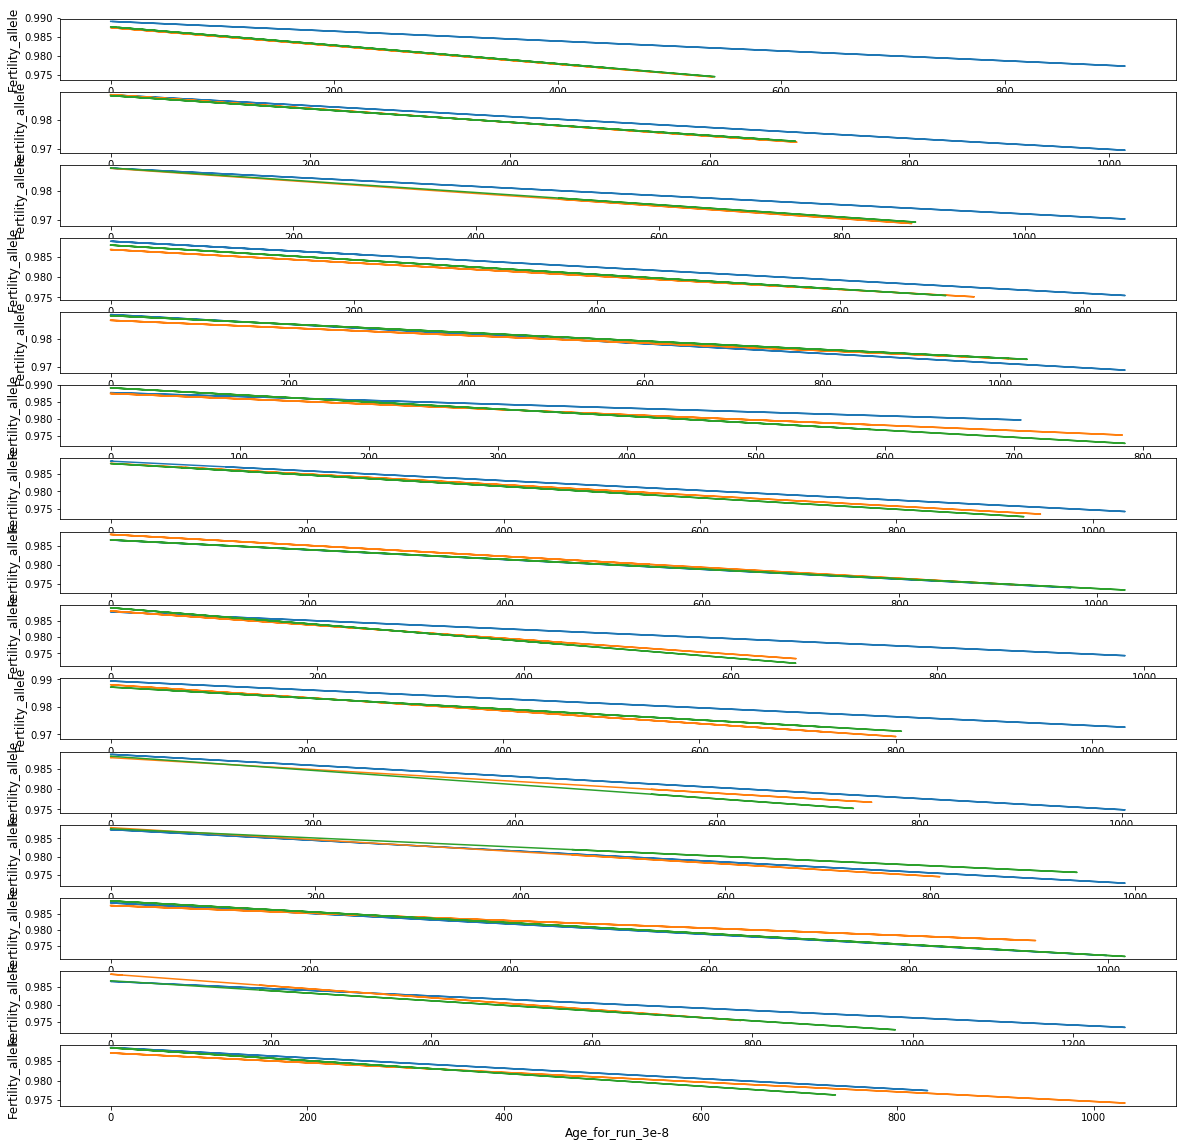

In [283]:
R2_score_list_pop=[]
R2_score_list_pop_1=[]
R2_score_list_pop_2=[]
intercept_list_pop=[]
intercept_list_pop_1=[]
intercept_list_pop_2=[]
slope_list_pop=[]
slope_list_pop_1=[]
slope_list_pop_2=[]
plt.figure(1, figsize=(20,20))
index_line=1
list_namefile,dico_file,dico_file_1,dico_file_2=dico_data_mig("analyses/scaling_M_4/","Age","Fertility_allele","allele",0,1)
for i in list_namefile :
    plt.subplot(len(list_namefile),1,index_line)
    if i+"_x_params" in dico_file and i+"_y_params" in dico_file:
        #plt.plot(dico_file[i+"_x_params"],dico_file[i+"_y_params"],'.',label="pop before migration")
        lm = LinearRegression().fit(np.array(dico_file[i+"_x_params"]).reshape(-1, 1), np.array(dico_file[i+"_y_params"]))
        plt.plot(dico_file[i+"_x_params"], lm.predict(np.array(dico_file[i+"_x_params"]).reshape(-1, 1)))
    #plt.plot(dico_file_1[i+"_x_params"],dico_file_1[i+"_y_params"],'.',label="pop1")
    lm1 = LinearRegression().fit(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1), np.array(dico_file_1[i+"_y_params"]))
    plt.plot(dico_file_1[i+"_x_params"], lm1.predict(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1)))
    #plt.plot(dico_file_2[i+"_x_params"],dico_file_2[i+"_y_params"],'.',label="pop2")
    lm2 = LinearRegression().fit(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1), np.array(dico_file_2[i+"_y_params"]))
    plt.plot(dico_file_2[i+"_x_params"], lm2.predict(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1)))
    plt.ylabel("Fertility_allele", fontsize = 12)
    plt.xlabel("Age"+"_for_run_"+i, fontsize = 12)
    score_lm = r2_score(np.array(dico_file[i+"_y_params"]),lm.predict(np.array(dico_file[i+"_x_params"]).reshape(-1, 1)))
    score_lm1 = r2_score(np.array(dico_file_1[i+"_y_params"]),lm1.predict(np.array(dico_file_1[i+"_x_params"]).reshape(-1, 1)))
    score_lm2 = r2_score(np.array(dico_file_2[i+"_y_params"]),lm2.predict(np.array(dico_file_2[i+"_x_params"]).reshape(-1, 1)))
    R2_score_list_pop.append(score_lm)
    R2_score_list_pop_1.append(score_lm1)
    R2_score_list_pop_2.append(score_lm2)
    intercept_list_pop.append(lm.intercept_)
    intercept_list_pop_1.append(lm1.intercept_)
    intercept_list_pop_2.append(lm2.intercept_)
    slope_list_pop.append(lm.coef_)
    slope_list_pop_1.append(lm1.coef_)
    slope_list_pop_2.append(lm2.coef_)
    index_line=index_line+1
print(slope_list_pop_1)
print(slope_list_pop_2)

### Scaling

In [52]:
def readscalingexperimentmigration(target_folder_path , scaling_param_name, param_names_allele, param_names_trace, withoutneutral, withoutnan):
    list_files = sorted(os.listdir(target_folder_path))
    stat_dict_allele = dict()
    stat_dict_allele_1 = dict()
    stat_dict_allele_2 = dict()
    for param in param_names_allele:
        stat_dict_allele[scaling_param_name]=[]
        stat_dict_allele[param+"_mean"]=[]
        stat_dict_allele[param+"_variance"]=[]
        stat_dict_allele_1[scaling_param_name]=[]
        stat_dict_allele_1[param+"_mean"]=[]
        stat_dict_allele_1[param+"_variance"]=[]
        stat_dict_allele_2[scaling_param_name]=[]
        stat_dict_allele_2[param+"_mean"]=[]
        stat_dict_allele_2[param+"_variance"]=[]
    stat_dict_trace = dict()
    stat_dict_trace_1 = dict()
    stat_dict_trace_2 = dict()
    for param in param_names_trace:
        stat_dict_trace[scaling_param_name]=[]
        stat_dict_trace[param+"_mean"]=[]
        stat_dict_trace[param+"_variance"]=[]
        stat_dict_trace_1[scaling_param_name]=[]
        stat_dict_trace_1[param+"_mean"]=[]
        stat_dict_trace_1[param+"_variance"]=[]
        stat_dict_trace_2[scaling_param_name]=[]
        stat_dict_trace_2[param+"_mean"]=[]
        stat_dict_trace_2[param+"_variance"]=[]
    for file_name in list_files :
        if file_name.split(".")[1]=="allele" :
            if (file_name.split(".")[0]).split("_")[-1]=="1":
                stat_dict_allele_1[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            if (file_name.split(".")[0]).split("_")[-1]=="2":
                stat_dict_allele_2[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            else:
                stat_dict_allele[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            data_file = readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1], withoutneutral, withoutnan)
            for key in data_file.keys():
                if (file_name.split(".")[0]).split("_")[-1]=="1":
                    #print(key)
                    (stat_dict_allele_1[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_allele_1[key+"_variance"]).append(np.var(data_file[key]))
                if (file_name.split(".")[0]).split("_")[-1]=="2":
                    #print(key)
                    (stat_dict_allele_2[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_allele_2[key+"_variance"]).append(np.var(data_file[key]))
                else :
                    #print(key)
                    (stat_dict_allele[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_allele[key+"_variance"]).append(np.var(data_file[key]))
        elif file_name.split(".")[1]=="trace" :
            if (file_name.split(".")[0]).split("_")[-1]=="1":
                stat_dict_trace_1[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))
            if (file_name.split(".")[0]).split("_")[-1]=="2":
                stat_dict_trace_2[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))  
            else :
                stat_dict_trace[scaling_param_name].append(float((file_name.split(".")[0]).split("_")[2]))  
            data_file = readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1], withoutneutral, withoutnan)
            for key in data_file.keys():
                if (file_name.split(".")[0]).split("_")[-1]=="1":
                    (stat_dict_trace_1[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_trace_1[key+"_variance"]).append(np.var(data_file[key]))
                if (file_name.split(".")[0]).split("_")[-1]=="2":
                    (stat_dict_trace_2[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_trace_2[key+"_variance"]).append(np.var(data_file[key]))
                else :
                    (stat_dict_trace[key+"_mean"]).append(np.mean(data_file[key]))
                    (stat_dict_trace[key+"_variance"]).append(np.var(data_file[key]))
    return (stat_dict_allele,stat_dict_allele_1,stat_dict_allele_2,stat_dict_trace,stat_dict_trace_1,stat_dict_trace_2)

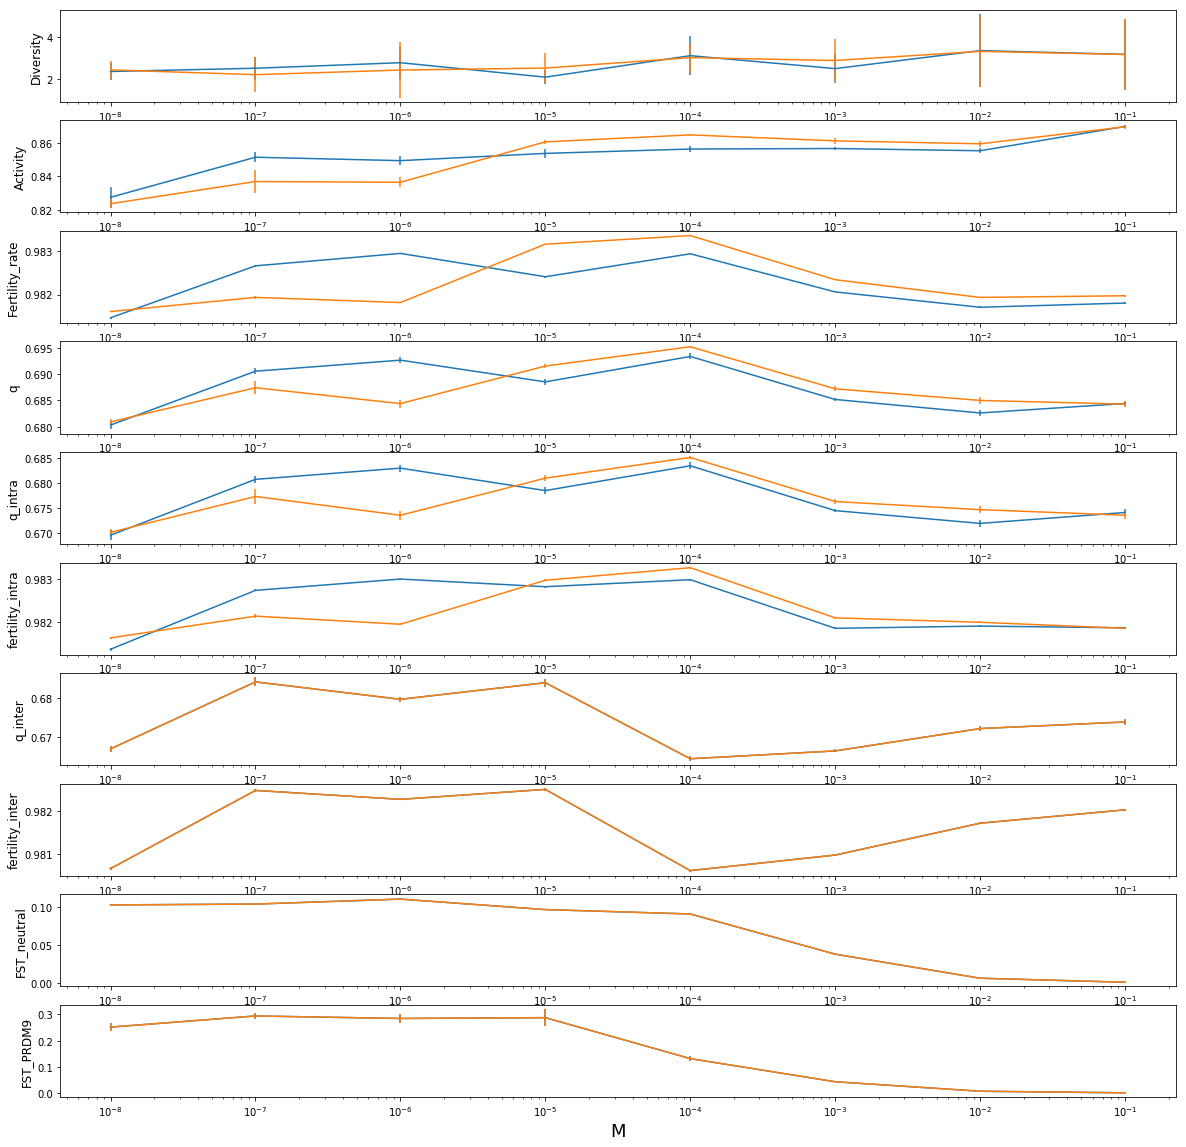

In [389]:
allele,allele1,allele2,trace,trace1,trace2=readscalingexperimentmigration(target_folder_path="analyses/scaling_M_3/" , scaling_param_name="M", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele","Fertility_allele"], param_names_trace=["Generation_number","Number_of_allele","Total_nb_allele","Total_number_of_allele","Diversity","Activity","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q","q_intra","fertility_intra","q_inter","fertility_inter","FST_neutral","FST_PRDM9"],withoutneutral=0, withoutnan=0)
scaling_param_name="M"
param_to_plot=["Diversity","Activity","Fertility_rate","q","q_intra","fertility_intra","q_inter","fertility_inter","FST_neutral","FST_PRDM9"]
n=len(param_to_plot)

plt.figure(1, figsize=(20,20))
for index_parameter in range(n):
    plt.subplot(n,1,index_parameter+1)
    plt.errorbar(trace1[scaling_param_name][1:len(trace1[scaling_param_name])], trace1[param_to_plot[index_parameter]+'_mean'][1:len(trace1[scaling_param_name])], trace1[param_to_plot[index_parameter]+'_variance'][1:len(trace1[scaling_param_name])])
    plt.errorbar(trace2[scaling_param_name][1:len(trace2[scaling_param_name])], trace2[param_to_plot[index_parameter]+'_mean'][1:len(trace2[scaling_param_name])], trace2[param_to_plot[index_parameter]+'_variance'][1:len(trace2[scaling_param_name])])
    plt.xscale('log')
    plt.ylabel(param_to_plot[index_parameter], fontsize = 12)
    plt.xlabel(scaling_param_name, fontsize = 18)

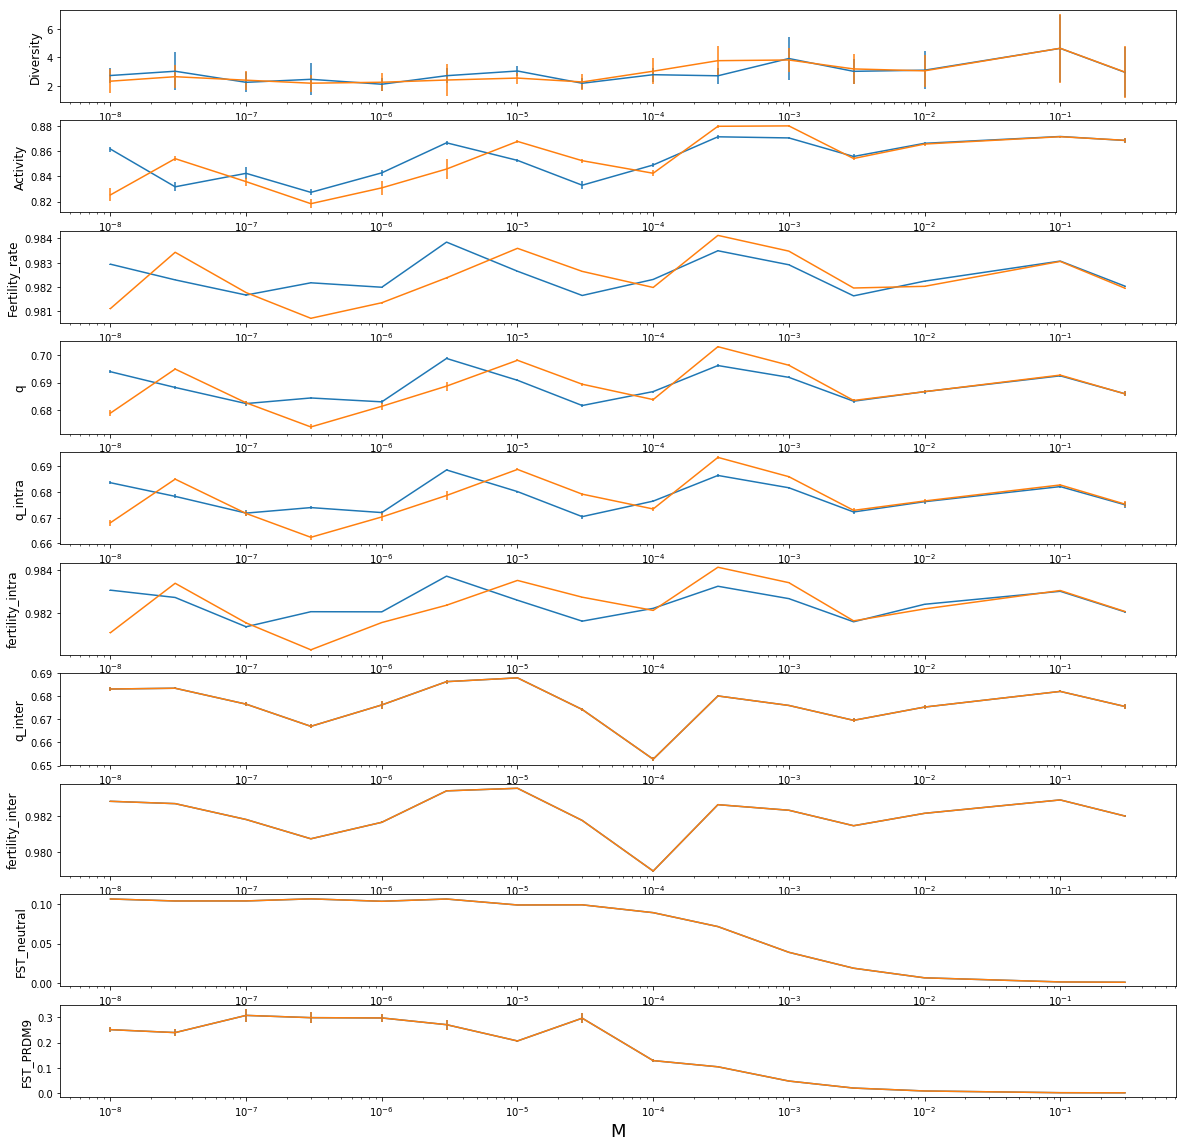

In [386]:
allele,allele1,allele2,trace,trace1,trace2=readscalingexperimentmigration(target_folder_path="analyses/scaling_M_4/" , scaling_param_name="M", param_names_allele=["Generation_number","Allele_number","Frequency","Activity","Age","q_allele","Fertility_allele","mean_affinity"], param_names_trace=["Generation_number","Number_of_allele","Total_nb_allele","Total_number_of_allele","Diversity","Activity","Mean_Age","Time","Fertility_rate","2_DSB_on_one_site_rate","No_DSB_rate","No_symmetrical_sites_rate","q","q_intra","fertility_intra","q_inter","fertility_inter","FST_neutral","FST_PRDM9"], withoutneutral=0, withoutnan=0)
scaling_param_name="M"
param_to_plot=["Diversity","Activity","Fertility_rate","q","q_intra","fertility_intra","q_inter","fertility_inter","FST_neutral","FST_PRDM9"]
n=len(param_to_plot)

plt.figure(1, figsize=(20,20))
#print(trace1)
cletodelete=[]
cletodelete1=[]
cletodelete2=[]
for cle in trace:
    if len(trace[cle])==0:
        cletodelete.append(cle)
    if len(trace1[cle])==0:
        cletodelete1.append(cle)
    if len(trace2[cle])==0:
        cletodelete2.append(cle)
for cle in cletodelete:
    del trace[cle]
for cle in cletodelete1:
    del trace1[cle]
for cle in cletodelete2:
    del trace2[cle]
df_trace_1 = pd.DataFrame(trace1,index = trace1["M"])
df_trace_1.sort_values(by = "M", inplace = True)
df_trace_2 = pd.DataFrame(trace2,index = trace2["M"])
df_trace_2.sort_values(by = "M", inplace = True)
for index_parameter in range(n):
    plt.subplot(n,1,index_parameter+1)
    plt.errorbar(df_trace_1[scaling_param_name], df_trace_1[param_to_plot[index_parameter]+'_mean'], df_trace_1[param_to_plot[index_parameter]+'_variance'])
    plt.errorbar(df_trace_2[scaling_param_name], df_trace_2[param_to_plot[index_parameter]+'_mean'], df_trace_2[param_to_plot[index_parameter]+'_variance'])
    plt.xscale('log')
    plt.ylabel(param_to_plot[index_parameter], fontsize = 12)
    plt.xlabel(scaling_param_name, fontsize = 18)

In [387]:
selct_coeff=[]
selct_coeff1=[]
selct_coeff2=[]
fourNs=[]
fourNs1=[]
fourNs2=[]
for index in range(len(trace1["Fertility_rate"+'_mean'])):
    selct_coeff1.append(np.log(intercept_list_pop_1[index])-np.log(trace1["Fertility_rate"+'_mean'][index]))
    fourNs1.append(4*1000*selct_coeff1[index])
    selct_coeff2.append(np.log(intercept_list_pop_2[index])-np.log(trace2["Fertility_rate"+'_mean'][index]))
    fourNs2.append(4*1000*selct_coeff2[index])
#print(selct_coeff1)
#print(selct_coeff2)
print(fourNs1)
print(fourNs2)

[18.046403764296635, 24.955333339671906, 19.812711966341531, 17.884468801084761, 16.478540867142435, 22.200292387481316, 25.730716637725088, 20.254489984191508, 23.891670661012483, 26.088127309976116, 16.990341267203871, 25.505712772973808, 14.882136716583187, 25.804597207492709, 19.585668893497591]
[19.012437705635264, 24.509402822300409, 18.031636226032063, 23.627557738698695, 19.386661999208325, 31.539619875274621, 25.121923939489143, 21.941121184035275, 28.291375876077357, 21.267287569520761, 15.829493348158225, 20.169835186212563, 26.723761109604851, 24.342971749149676, 20.317420109146084]


Text(0.5,0,'M')

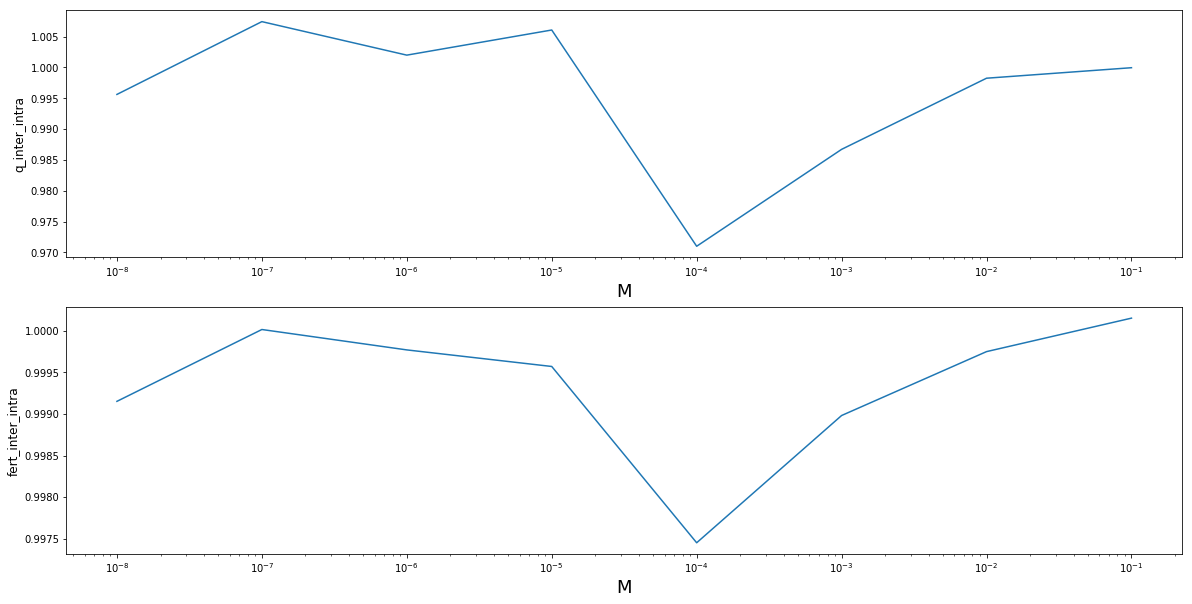

In [390]:
q_inter_intra=[]
fert_inter_intra=[]
for i in range(len(trace1["q_inter"+'_mean'])):
    if i != 0:
        q_inter_intra.append(trace1["q_inter"+'_mean'][i]/((trace1["q_intra"+'_mean'][i]+trace2["q_intra"+'_mean'][i])/2))
        fert_inter_intra.append(trace1["fertility_inter"+'_mean'][i]/((trace1["fertility_intra"+'_mean'][i]+trace2["fertility_intra"+'_mean'][i])/2))
plt.figure(1, figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(trace1["M"][1:len(trace1["q_inter"+'_mean'])],q_inter_intra)
plt.xscale('log')
plt.ylabel("q_inter_intra", fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 18)
plt.subplot(2,1,2)
plt.plot(trace1["M"][1:len(trace1["q_inter"+'_mean'])],fert_inter_intra)
plt.xscale('log')
plt.ylabel("fert_inter_intra", fontsize = 12)
plt.xlabel(scaling_param_name, fontsize = 18)

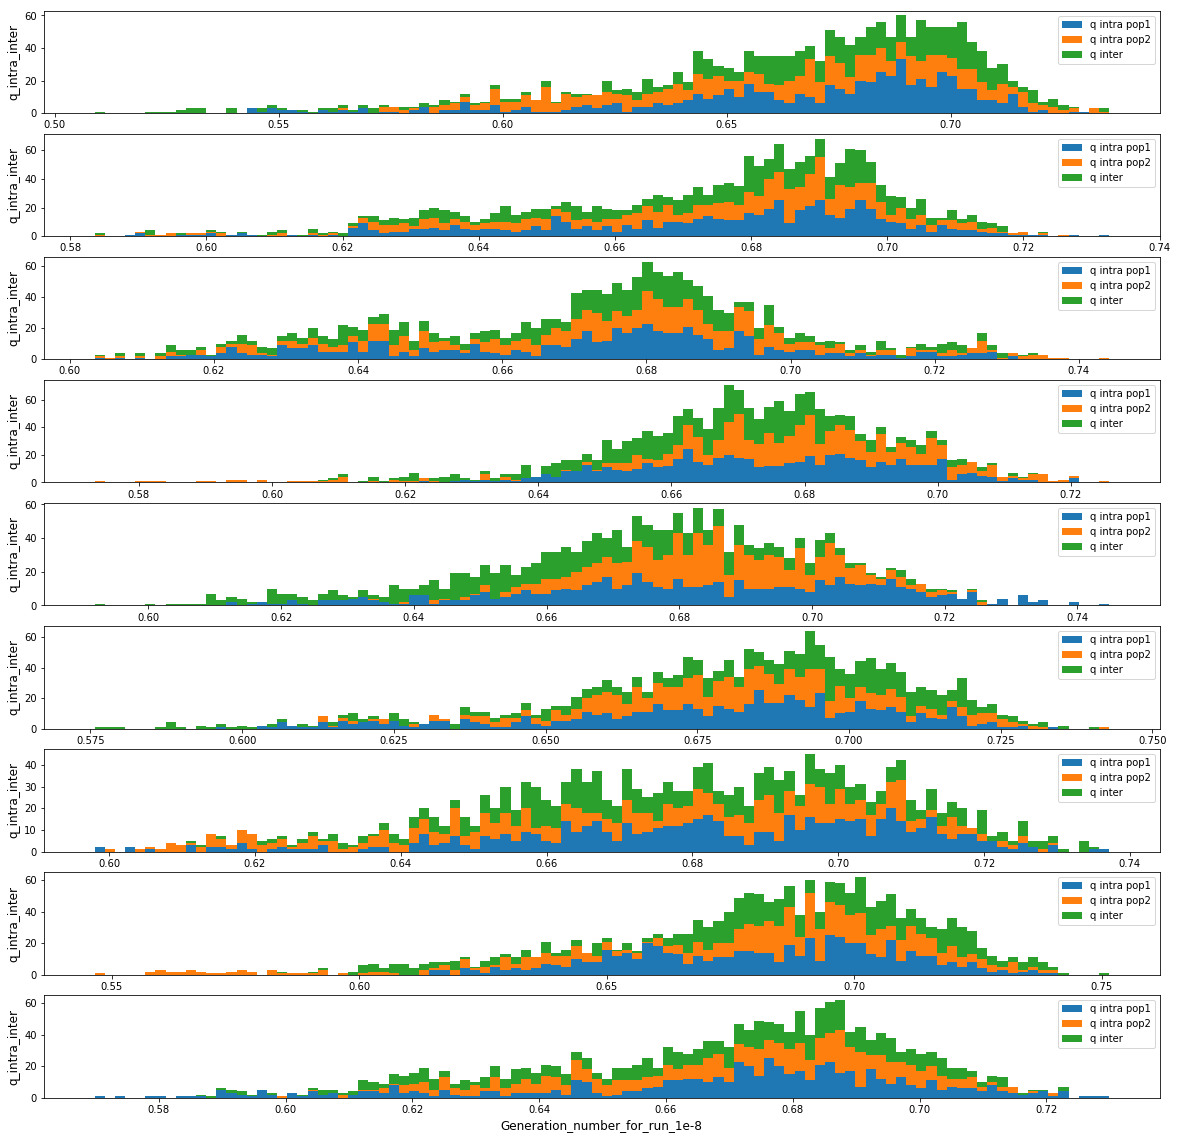

In [396]:
plt.figure(1, figsize=(20,20))
index_line=1
list_namefile,dico_file_inter,dico_file_1_inter,dico_file_2_inter=dico_data_mig("analyses/scaling_M_3/","Generation_number","q_inter", "trace",0,0)
list_namefile,dico_file_intra,dico_file_1_intra,dico_file_2_intra=dico_data_mig("analyses/scaling_M_3/","Generation_number","q_intra", "trace",0,0)
for i in list_namefile :
    plt.subplot(len(list_namefile),1,index_line)
    #if i+"_x_params" in dico_file_intra and i+"_y_params" in dico_file_intra:
        #plt.plot(dico_file_intra[i+"_x_params"],dico_file_intra[i+"_y_params"],'.',label="q intra before mig")
    plt.hist([dico_file_1_intra[i+"_y_params"],dico_file_2_intra[i+"_y_params"],dico_file_1_inter[i+"_y_params"]], bins = 100,label=["q intra pop1","q intra pop2","q inter"],histtype = 'barstacked')
    #plt.hist(dico_file_1_intra[i+"_y_params"], bins = 100)
    #plt.hist(dico_file_2_intra[i+"_y_params"], bins = 100)
    #plt.hist(dico_file_1_inter[i+"_y_params"], bins = 100)
    #plt.plot(dico_file_1_intra[i+"_x_params"],dico_file_1_intra[i+"_y_params"],'.',label="q intra pop1")
    #plt.plot(dico_file_2_intra[i+"_x_params"],dico_file_2_intra[i+"_y_params"],'.',label="q intra pop2")
    #plt.plot(dico_file_1_inter[i+"_x_params"],dico_file_1_inter[i+"_y_params"],'.',label="q inter")
    plt.ylabel("q_intra_inter", fontsize = 12)
    plt.xlabel("Generation_number"+"_for_run_"+i, fontsize = 12)
    plt.legend()
    index_line=index_line+1